# PST 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import ttest_ind
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import levene
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# importing data
annual_concentration = pd.read_csv('inputs/AnnualConcentration_Brisbane.csv')
annual_flow = pd.read_csv('inputs/AnnualFlow_Brisbane.csv')
annual_load = pd.read_csv('inputs/AnnualLoad_Brisbane.csv')
daily_load = pd.read_csv('inputs/DailyLoad_Brisbane.csv')

## 1. Data Inspection and Cleansing

The Queensland Government Tahbil Water Quality data (https://apps.des.qld.gov.au/water-data-portal/) provides an extensive overview of water flow data and pollution. From the Portal, 4 different data sets were used within the following task, reduced to sites around the Brisbane area:

 -Annual Concentration: Involving the concentrations of eight different analytes measured at multiple sites over the given time periods.
 -Annual Flow: Involving the flow rates of water in $m^3s^{-1}$ at multiple sites over the given time periods.
 -Annual Load: Involving the total estimated mass of an analyte at multiple sites over the given time periods. Contains further information on the total water discharge in the given site (including percentage measured/modelled), area of the monitored site, and given yield for every $m^{}2$ in the site.
 -Daily Load: Involving the total interpolated load of each day measured.


To correctly Inspect and clean this data, key calculations and quality measurements within this data must first be explained. First is the load calculation. Two independent measurements are made at each site — flow data and analyte concentration. To produce a load value from this, one of two calculations can be made. If the measurements are reasonably representatively sampled, the average load can be calculated by:
$$
Load = \displaystyle\sum_{j=1}^n \frac{c_j + c_(j+1)}{2}q_j
$$
where cj is the jth sample concentration, qj is the inter-sample total discharge volume.
If the samples are not representatively sampled, the Beale ratio is used:
$$
Load = q \left(\frac{l}{\bar{l_q}}\right) \left\{\frac{1+\frac{1}{N}\frac{\rho \sigma_L \sigma_Q}{\bar{l_q}}}{1+\frac{1}{N}\frac{\sigma_Q^2}{\bar{q}^2}}\right\}
$$
where Q is the total discharge volume for the period, l is the average load for a sample, L is the observed load, q is the average of N discharge measurements, $\sigma$ is the standard error of L, and p is the correlation coefficient for L and Q.

This data includes various quality codes which provide information into the reliability of the concentration samples in accordance to the \href{https://water-monitoring.information.qld.gov.au/wini/documents/webglossary.pdf}{Water Monitoring Information Portal}. In general, a lower number is better. The quality codes for the load data pertain to the number of samples in the top five percent of water discharge, and the ratio of the maximum discharge samples to the total maximum discharge. That is, a sample set that experiences a high flow rate will be given a higher quality rating, as data on analyte concentration at periods of high discharge are required to reliably capture annual load.

The last quality assurance is based on quantification limits on analyte concentrations. If an analyte is measured below the quantification limit, it is given a concentration value of half of the limit. This information is stored as a '<' operator in the operator column.

With this information, the data sets can be sufficiently cleaned.

 -Annual Concentration: This data set starts at 9242 entries. Firstly, I removed all entries without a quality code of 10, which is the best quality data. Next, I removed any duplicate entries present, utilising the subset ['Analyte','Sample Reference']. Lastly, to maintain a similar date format seen in Annual flow and Daily Load, I formatted all days or months value in 'Date Time' to have a consistent length (2/2/2019 to 02/02/2019). These steps reduced the size by 0.1% down to 1927
 -Annual Flow: This data set starts at 201576 entries. Over half of the entries in this set have a quality reading of 15, indicating that there was no flow, which provides little use for further analysis. The next largest subsample is at a quality of 10, which is ~30% of all samples, followed by 20 at ~10\%. As such, this dataset was also cleaned by reducing the entries to a quality code of 10. As done in annual flow, any duplicates were removed again, with the subset ['Site Code', 'Sampling Year', 'Date Time']. The clean dataset was reduced by ~68% to 64111.
 -Annual Load: This dataset starts at 242 entries. Due to the small size of this dataset, the cleaning remained slightly more lenient than previous sets. First, it was reduced to entries where the quality code was either 'Good' or 'Excellent'. Next, any entry with a 'Flow Unknown %' as a value was removed, to maintain 100\% total flow consistency. Lastly, duplicates were removed by the same subset as Annual Flow. This reduced the dataset by 18\% to 198.
-Daily Load: This dataset starts at 84358 entries. No cleaning was done to this dataset, as each entry is inherently less reliable than the annual load value.

Furthermore, in further use of the Annual concentration and Annual Load datasets, any analyte value that is a total number is omitted, as these are not comparable to the individual analyte values. This was done by checking if the analyte name begins with 'Total'.

Lastly, no missing value was filled with the average or median, as these values wouldn't bring new information forward, and would reduce the reliability of any statistical test.

In [4]:
quality_codes = pd.DataFrame()
quality_codes['quality codes'] = annual_flow['Quality Code'].unique()
quality_codes['counts'] = pd.Series([len(annual_flow[annual_flow['Quality Code'] == code]) for code in quality_codes['quality codes']])
quality_codes

,quality codes,counts
0,20,17790
1,60,5078
2,15,105008
3,10,64111
4,30,6639
5,255,79
6,40,2820
7,160,51


So there is more unlisted quality codes? Right here: https://water-monitoring.information.qld.gov.au/wini/documents/webglossary.pdf
- 20 is Verified 20
- 10 is verified 10
- 60 is Estimated, and only contains height and flow
- 15 is Water level below threshold(no flow)

In [5]:
quality_codes = pd.DataFrame()
quality_codes['quality codes'] = annual_concentration['Quality Code'].unique()
quality_codes['counts'] = annual_concentration['Quality Code'].value_counts().values
quality_codes

,quality codes,counts
0,10,9228
1,930,12
2,20,2


I think only using 10 here is fine

So first, lets reduce the data by these quality codes

In [78]:
def date_formatter(date_time):
    day = date_time.split('/')[0]
    if len(day) == 1:
        day = '0' + day
    month = date_time.split('/')[1]
    if len(month) == 1:
        month = '0' + month
    year_plus = date_time.split('/')[2]
    return f'{day}/{month}/{year_plus}'
annual_concentration_clean = annual_concentration[annual_concentration['Quality Code'] == 10]
annual_concentration_clean.drop_duplicates(subset=['Analyte','Sample Reference'], keep='first', inplace=True)
annual_concentration_clean['Date Time'] = annual_concentration_clean['Date Time'].apply(date_formatter)
annual_concentration_clean.reset_index(drop=True, inplace=True)

annual_flow_clean = annual_flow[(annual_flow['Quality Code'] == 10)]
annual_flow_clean.drop_duplicates(subset=['Site Code', 'Sampling Year', 'Date Time'], keep='first', inplace=True)
annual_flow_clean.reset_index(drop=True, inplace=True)

annual_load_clean = annual_load[(annual_load['Quality Rating'] == 'Excellent') |
                                (annual_load['Quality Rating'] == 'Good') |
                                (annual_load['Flow Unknown (%)'] is True)]
annual_load_clean.drop_duplicates(subset=['Site Code', 'Sampling Year', 'Analyte'], keep='first', inplace=True)
annual_load_clean.reset_index(drop=True, inplace=True)


print(f'Annual Concentration Cleaning: {annual_concentration.shape[0]} to {annual_concentration_clean.shape[0]}')
print(f'Annual Flow Cleaning: {annual_flow.shape[0]} to {annual_flow_clean.shape[0]}')
print(f'Annual Load Cleaning: {annual_load.shape[0]} to {annual_load_clean.shape[0]}')

Annual Concentration Cleaning: 9242 to 9227
Annual Flow Cleaning: 201576 to 64111
Annual Load Cleaning: 242 to 198


C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\2172821113.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_concentration_clean.drop_duplicates(subset=['Analyte','Sample Reference'], keep='first', inplace=True)
C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\2172821113.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_concentration_clean['Date Time'] = annual_concentration_clean['Date Time'].apply(date_formatter)
C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\2172821113.py:16: SettingWithCopyWarning: 
A value is trying to be set on a c

In [7]:
site_codes = annual_concentration_clean['Site Code'].unique()
site_codes

array(['143107A', '143108A', '143209B', '143210B', '143229A'],
      dtype=object)

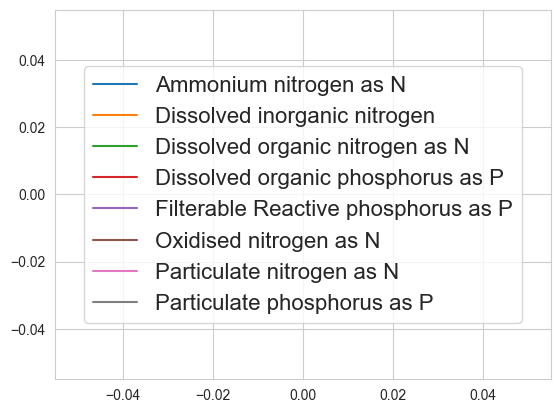

In [8]:
# plotting the legend only
all_analyte = annual_concentration_clean['Analyte'].unique()
not_total = [i[:5] != 'Total' for i in all_analyte]
all_analyte = all_analyte[not_total] # removes any total value
for analyte in all_analyte:
    plt.plot([], [], label=analyte)

plt.legend(loc='center', fontsize=16)

Each cell has a commented legend function, however including the same legend for each cell is not necessary, as each site/each year has the same analytes:

In [9]:
all_analyte

array(['Ammonium nitrogen as N', 'Dissolved inorganic nitrogen',
       'Dissolved organic nitrogen as N',
       'Dissolved organic phosphorus as P',
       'Filterable Reactive phosphorus as P', 'Oxidised nitrogen as N',
       'Particulate nitrogen as N', 'Particulate phosphorus as P'],
      dtype=object)

Because I spent time on it and don't want to omit it, here is a description of each analyte:

  - Ammonium Nitrogen (AN): It is a byproduct of organic matter breakdown (ammonification) and can also come from sewage discharge. In aquatic systems, ammonium is an important nutrient for plant growth, but at high levels, it can indicate pollution and contribute to eutrophication [2, 7].

  - Dissolved inorganic nitrogen (DIN): It enters water bodies through runoff, atmospheric deposition, and wastewater. High levels of it can lead to excessive algal blooms, affecting water quality and ecosystem health [5].

  - Dissolved organic nitrogen(DON): Is a result of the breakdown of organic matter, such as plant and animal remains, and can be introduced through agricultural runoff, sewage, and atmospheric deposition [5, 6].

  - Dissolved organic phosphorous (DOP): It is derived from the decomposition of organic material and can also enter water systems through runoff containing organic waste, detergents, and fertilisers. It is not immediately available for plant uptake but can be mineralised into bioavailable forms. Its presence indicates the potential for phosphorus cycling within the water body [3].

  - Filterable Reactive phosphorous (FRP): It enters water systems through sewage, agricultural runoff, and natural erosion of rocks. It is a key nutrient that can directly stimulate algal growth. Its levels in freshwater are often used as an indicator of potential eutrophication, as high concentrations can lead to harmful algal blooms [1].

  - Oxidised nitrogen (ON): It enters freshwater from agricultural runoff, atmospheric deposition, and wastewater. Elevated levels are often associated with agricultural runoff and can contribute to eutrophication [3, 8].

  - Particulate nitrogen (PN)): It is derived from soil erosion, organic matter, and biological sources like phytoplankton. It often increases after rain events that cause soil erosion [7].

  - Particulate phosphorous (PP): It often enters water through runoff and erosion. It can be a long-term source of phosphorus as it slowly converts to bioavailable forms, affecting water quality and contributing to algal blooms over time [7, 4].

1. Dodds, W. K. 2003, Journal of Phycology, 39, 840
2. Galloway, J. N., Aber, J. D., Erisman, J. W., et al. 2003, Bioscience, 53, 341
3. Howarth, R. W., Sharpley, A., & Walker, D. 2002, Estuaries, 25, 656
4. Rabalais, N. N., Turner, R. E., & Wiseman Jr, W. J. 2002, Annual Review of ecology and
Systematics, 33, 235
5. Seitzinger, S. P. 1988, Limnology and oceanography, 33, 702
6. Sipler, R. E., & Bronk, D. A. 2015, Biogeochemistry of marine dissolved organic matter, 127
7. Smith, V. H., Tilman, G. D., & Nekola, J. C. 1999, Environmental pollution, 100, 179
8. Wetzel, R. G. 2001, Limnology: lake and river ecosystems (gulf professional publishing)

Setting up shared data

In [10]:
import matplotlib.colors as mcolors
colours = [mcolors.TABLEAU_COLORS[colour] for colour in mcolors.TABLEAU_COLORS.keys()]
all_analyte = annual_concentration_clean['Analyte'].unique()

C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\518710786.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, fontsize=10, rotation=0)
C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\518710786.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, fontsize=10, rotation=0)
C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\518710786.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, fontsize=10, rotation=0)
C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\518710786.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, fontsize=10, rotation=0)
C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\518710786.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, fontsize=10, rotatio

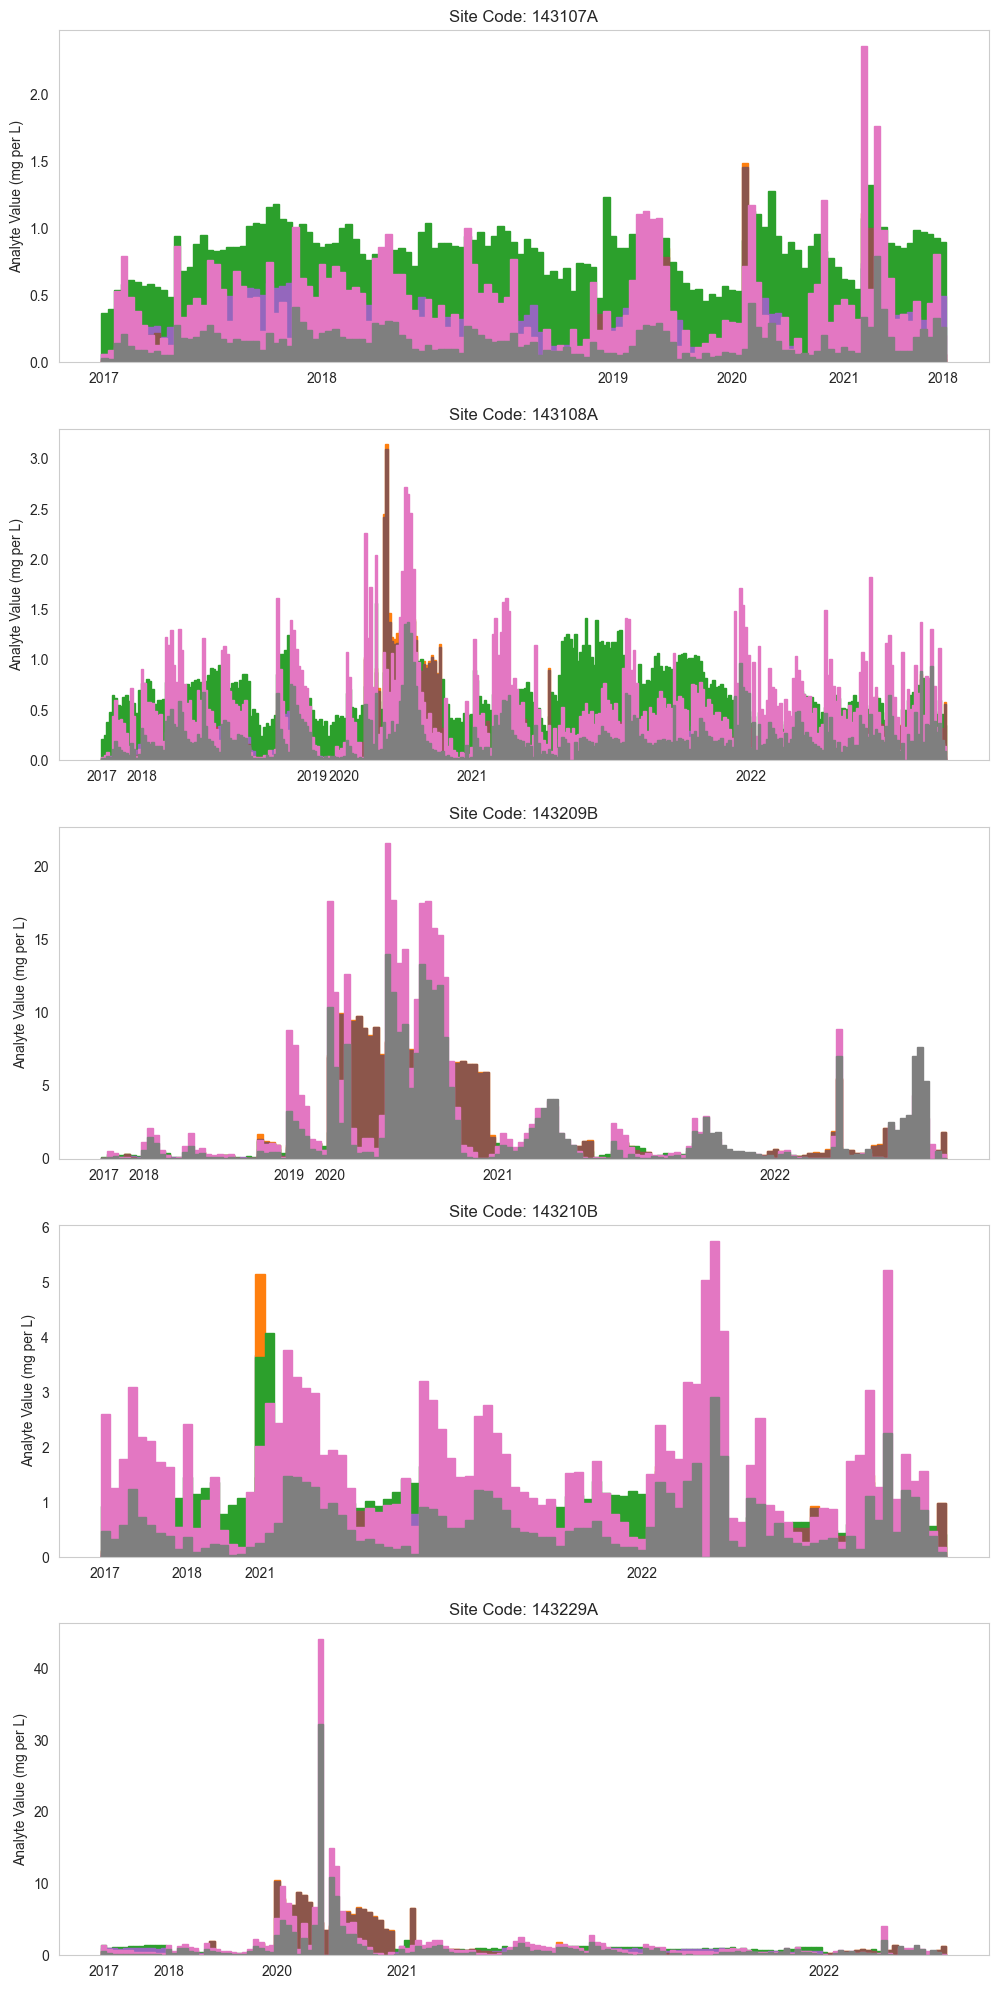

In [11]:
fig, axes = plt.subplots(nrows=len(site_codes), figsize=(12, len(site_codes) * 5))

for i, site_code in enumerate(site_codes):
    all_times = annual_concentration_clean[annual_concentration_clean['Site Code'] == site_code]['Date Time'].unique()
    all_analyte = annual_concentration_clean[annual_concentration_clean['Site Code'] == site_code]['Analyte'].unique()
    not_total = [i[:5] != 'Total' for i in all_analyte]
    all_analyte = all_analyte[not_total]
    site_data = np.zeros((len(all_analyte), len(all_times)))
    for k, analyte in enumerate(all_analyte):
        for j, time in enumerate(all_times):
            if sum(annual_concentration_clean[(annual_concentration_clean['Site Code'] == site_code) &
                                          (annual_concentration_clean['Date Time'] == time) & (annual_concentration_clean['Analyte'] == analyte)]['Value (mg per L)']) > 0:
                site_data[k,j] = annual_concentration_clean[(annual_concentration_clean['Site Code'] == site_code) &
                                                            (annual_concentration_clean['Date Time'] == time) & (annual_concentration_clean['Analyte'] == analyte)]['Value (mg per L)'].iloc[0]
            else:
                site_data[k,j] = 0
        axes[i].bar(all_times, site_data[k], width=1, edgecolor=colours[k], label=analyte)

    axes[i].set_title(f'Site Code: {site_code}')
    axes[i].set_ylabel('Analyte Value (mg per L)')
    #axes[i].legend()
    #axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.canvas.draw() # needs to be done to access the xtickslabels
    ticker_keeper = '1216' # ONE AFTER THE MAGNA CARTER
    labels = [item.get_text().split('/')[2][:4] for item in axes[i].get_xticklabels()]
    for tick_id, date in enumerate(labels):
        if date == ticker_keeper:
            labels[tick_id] = ''
        else:
            ticker_keeper = date
    axes[i].set_xticklabels(labels, fontsize=10, rotation=0)
    axes[i].grid(False)

This is pretty overwhelming, however a couple important trends can be interpreted from this graph. Firstly, there is a large difference in the analyte makeup of each site (or site catchment area), as such this discrepancy should be considered for any visualisations that don't include each site. Next, there is clear analyte spikes, firstly in small cycles of peaks and troughts, then a very large spike throughout the 2019-2020 sampling year (in the graph it is early 2020). Not only is PN and PP much higher through this period, but there is much higher quantities of DIN and ON. As there was no sustained flooding during this period to explain this spike, it is likely that the cause is higher than average agricultural activity, or the 2019 bushfire period. This graph is called back to multiple times.

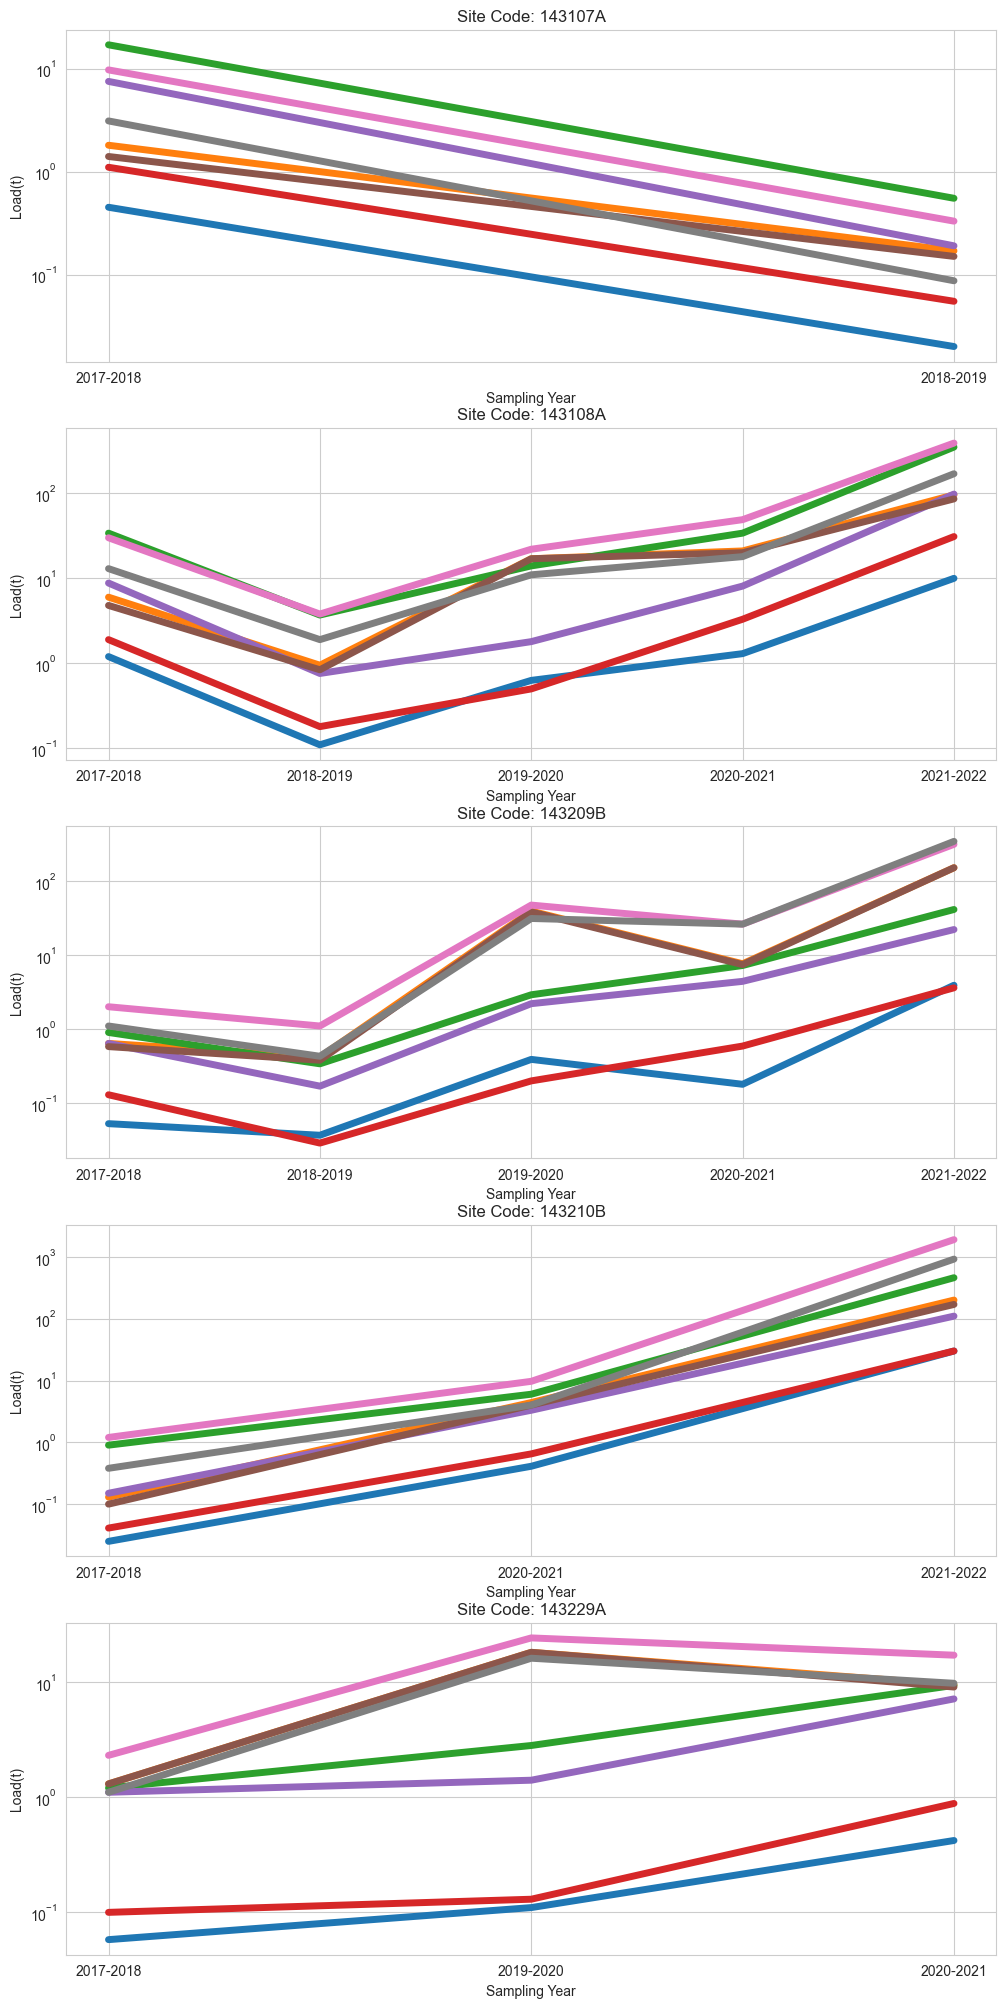

In [12]:
# Next a scatter plot between load and Discharge
fig, axes = plt.subplots(nrows=len(site_codes), figsize=(12, len(site_codes) * 5))

for i, site_code in enumerate(site_codes):
    site_data = annual_load_clean[annual_load_clean['Site Code'] == site_code]
    for analyte in all_analyte:
        analyte_data = site_data[site_data['Analyte'] == analyte]
        sns.lineplot(data=analyte_data, x='Sampling Year', y='Load (t)', linewidth = 5, ax=axes[i], legend=False)
    axes[i].set_title(f'Site Code: {site_code}')
    axes[i].set_ylabel('Load(t)')
    axes[i].set_yscale('log')
    #axes[i].legend()
    #axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

A quick few comparative graphs

Text(0.5, 1.0, 'Mean Flow of Sites Over Time')

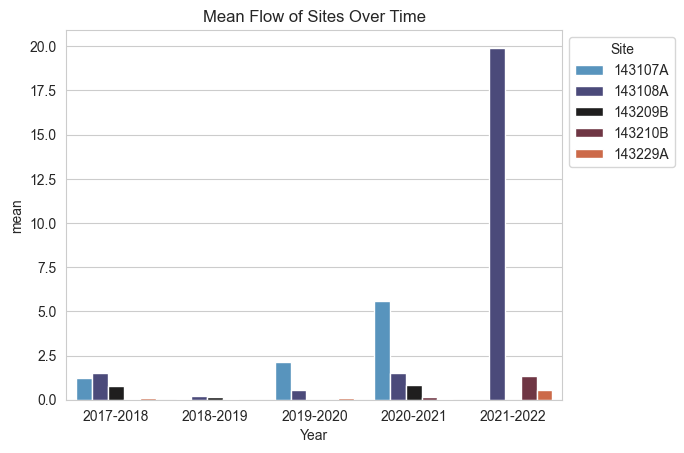

In [13]:
# Plotting Flow Over Time
site_codes = annual_flow_clean['Site Code'].unique()
all_years = annual_flow_clean['Sampling Year'].unique()
annual_flow_statistics_yearly = pd.DataFrame(columns = ['Year', 'Site', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])


for i, site_code in enumerate(site_codes):
    for j, year in enumerate(all_years):
        year_data = annual_flow_clean[annual_flow_clean['Site Code'] == site_code]
        year_data = year_data[year_data['Sampling Year'] == year]
        flow_data = year_data['Flow Cumecs']
        data_list = pd.DataFrame({'Year': [year], 'Site': [site_code]})
        data_list_all = pd.concat([data_list.T, flow_data.describe()]).T
        annual_flow_statistics_yearly = pd.concat([annual_flow_statistics_yearly, data_list_all], ignore_index=True)

ax = sns.barplot(annual_flow_statistics_yearly, x='Year',y='mean', hue='Site', palette="icefire")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f'Mean Flow of Sites Over Time')

In [14]:
site_codes = annual_concentration_clean['Site Code'].unique()
all_year = annual_concentration_clean['Sampling Year'].unique()

Text(0.5, 1.0, 'Mean Concentration of Analytes Over Time')

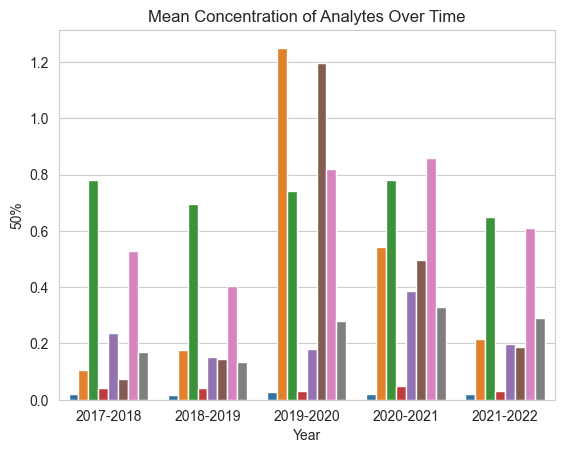

In [15]:
analyte_concentration_statistics_yearly = pd.DataFrame(columns = ['Year', 'Analyte', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])

for year in all_year:
    year_data = annual_concentration_clean[annual_concentration_clean['Sampling Year'] == year]
    for analyte in all_analyte:
        analyte_data = year_data[year_data['Analyte'] == analyte]['Value (mg per L)']
        data_list = pd.DataFrame({'Year': [year], 'Analyte': [analyte]})
        data_list_all = pd.concat([data_list.T, analyte_data.describe()]).T
        analyte_concentration_statistics_yearly = pd.concat([analyte_concentration_statistics_yearly, data_list_all], ignore_index=True)

ax = sns.barplot(analyte_concentration_statistics_yearly, x='Year',y='50%', hue='Analyte', legend=False)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.set_style("whitegrid")
plt.title(f'Mean Concentration of Analytes Over Time')

Generally, these two independently sampled variables have little in common, i produced clearer visualisation of it below. This is odd, especially considering many of the analytes are produced in organic matter or deposits, where erosion would be directly influenced by the flow rate.

In [16]:
# for each site in annual_concentration, finding the statistics of each analyte

analyte_concentration_statistics = pd.DataFrame()
for site_code in site_codes:
    site_data = annual_concentration_clean[annual_concentration_clean['Site Code'] == site_code]
    all_analyte = site_data['Analyte'].unique()
    not_total = [i[:5] != 'Total' for i in all_analyte]
    all_analyte = all_analyte[not_total]
    for analyte in all_analyte:
        analyte_data = site_data[site_data['Analyte'] == analyte]['Value (mg per L)']
        analyte_concentration_statistics[f'{site_code} - {analyte}'] = analyte_data.describe()


In [17]:

analyte_concentration_statistics_site = pd.DataFrame(columns = ['Site', 'Year', 'Analyte', 'mean flow', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])


for i, site in enumerate(site_codes):
    site_data = annual_concentration_clean[annual_concentration_clean['Site Code'] == site]
    for year in all_year:
        year_data = site_data[site_data['Sampling Year'] == year]
        year_data_flow = annual_flow_clean[annual_flow_clean['Site Code'] == site]
        year_data_flow = year_data_flow[year_data_flow['Sampling Year'] == year]
        flow_data = year_data_flow['Flow Cumecs']
        mean_flow = flow_data.mean()
        for analyte in all_analyte:
            analyte_data = year_data[year_data['Analyte'] == analyte]['Value (mg per L)']
            data_list = pd.DataFrame({'Site': site, 'Year': [year], 'Analyte': [analyte], 'mean flow': [mean_flow]})
            data_list_all = pd.concat([data_list.T, analyte_data.describe()]).T
            analyte_concentration_statistics_site = pd.concat([analyte_concentration_statistics_site, data_list_all], ignore_index=True)

analyte_concentration_statistics_site.dropna(inplace=True)

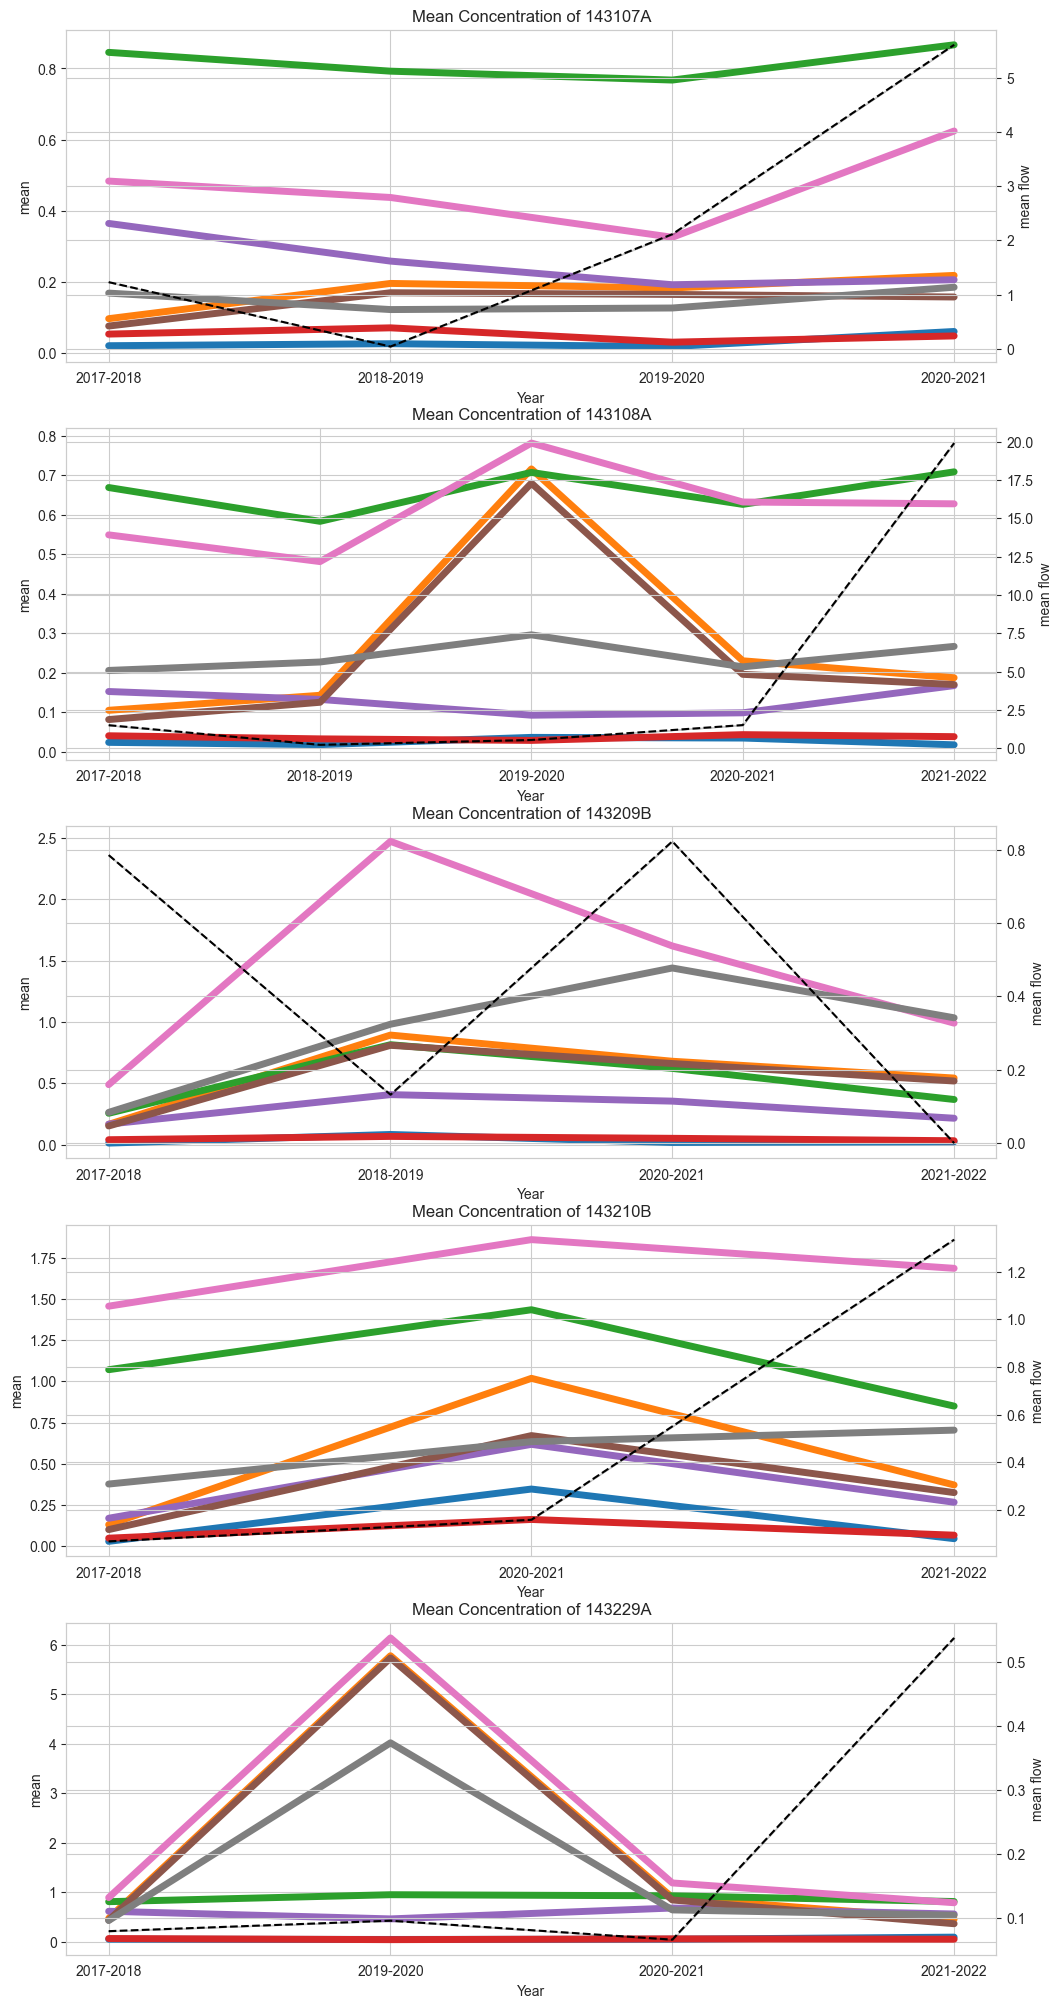

In [18]:
fig, axes = plt.subplots(nrows=len(site_codes), figsize=(12, len(site_codes) * 5))
for plot, site in enumerate(site_codes):
    axes_copy = axes[plot].twinx()
    ax = sns.lineplot(analyte_concentration_statistics_site[analyte_concentration_statistics_site['Site'] == site], x='Year',y='mean', hue='Analyte',linewidth = 5, ax=axes[plot], legend=False)
    sns.lineplot(analyte_concentration_statistics_site[analyte_concentration_statistics_site['Site'] == site], x='Year', y='mean flow', ls='--', color='black', ax=axes_copy)
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    axes[plot].set_title(f'Mean Concentration of {site}')

This is a much clearer visualisation, showing the flow rate in black, and the concentration of each analyte in different colours. This shows that the flow rate is not directly correlated with the concentration of any analyte, and that the concentration of each analyte is relatively stable over time.

In [19]:
site_codes = daily_load['Site Code'].unique()
all_year = daily_load['Sampling Year'].unique()

Text(0.5, 1.0, 'Mean Load (t) of Analytes Over Time')

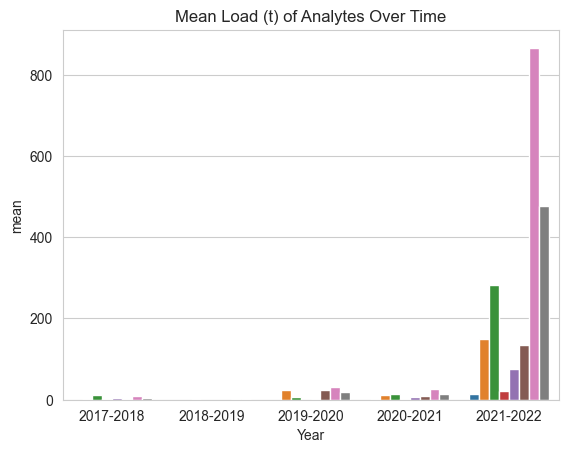

In [20]:
# average yearly load rates from annual_load_clean
load_weights_statistics_yearly = pd.DataFrame(columns = ['Year', 'Analyte', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])

for year in all_year:
    year_data = annual_load_clean[annual_load_clean['Sampling Year'] == year]
    for analyte in all_analyte:
        analyte_data = year_data[year_data['Analyte'] == analyte]['Load (t)']
        data_list = pd.DataFrame({'Year': [year], 'Analyte': [analyte]})
        data_list_all = pd.concat([data_list.T, analyte_data.describe()]).T
        load_weights_statistics_yearly = pd.concat([load_weights_statistics_yearly, data_list_all], ignore_index=True)

load_weights_statistics_yearly.dropna(inplace=True)
ax = sns.barplot(load_weights_statistics_yearly, x='Year',y='mean', hue='Analyte', legend=False)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f'Mean Load (t) of Analytes Over Time')

Got some good-looking graphs, onto the next section

## 2. Data Analysis

### Concentration Data

In [21]:
# showing the statistics calculated in an earlier cell
analyte_concentration_statistics_site

,Site,Year,Analyte,mean flow,mean,std,min,25%,50%,75%,max,count
0,143107A,2017-2018,Ammonium nitrogen as N,1.229497,0.020687,0.009668,0.004,0.014,0.02,0.025,0.053,67.0
1,143107A,2017-2018,Dissolved inorganic nitrogen,1.229497,0.096669,0.064451,0.0045,0.054,0.08,0.12525,0.325,68.0
2,143107A,2017-2018,Dissolved organic nitrogen as N,1.229497,0.845147,0.17119,0.37,0.8025,0.87,0.955,1.18,68.0
3,143107A,2017-2018,Dissolved organic phosphorus as P,1.229497,0.053382,0.029148,0.02,0.04,0.05,0.06,0.21,68.0
4,143107A,2017-2018,Filterable Reactive phosphorus as P,1.229497,0.364324,0.137721,0.048,0.26275,0.365,0.48675,0.607,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,143229A,2021-2022,Dissolved organic phosphorus as P,0.537093,0.049296,0.03348,0.02,0.02,0.04,0.07,0.15,71.0
196,143229A,2021-2022,Filterable Reactive phosphorus as P,0.537093,0.558625,0.291197,0.066,0.2645,0.61,0.837,1.03,72.0
197,143229A,2021-2022,Oxidised nitrogen as N,0.537093,0.362028,0.311726,0.026,0.13325,0.229,0.55575,1.38,72.0
198,143229A,2021-2022,Particulate nitrogen as N,0.537093,0.786111,0.620321,0.03,0.4575,0.6,0.985,4.02,72.0


In [22]:
site_codes = annual_concentration_clean['Site Code'].unique()
all_year = annual_concentration_clean['Sampling Year'].unique()

In [23]:
# getting the average concentration for each site and total counts
average_concentration = pd.DataFrame(columns=['Site', 'Analyte', 'mean', 'counts'])
for i, site in enumerate(site_codes):
    site_data = analyte_concentration_statistics_site[analyte_concentration_statistics_site['Site'] == site]
    for analyte in all_analyte:
        analyte_data = site_data[site_data['Analyte'] == analyte]
        data_list = pd.DataFrame({'Site': [site], 'Analyte': [analyte], 'mean' : [analyte_data['mean'].mean()], 'counts' : [analyte_data['count'].sum()]})
        average_concentration = pd.concat([average_concentration, data_list], ignore_index=True)

average_concentration

,Site,Analyte,mean,counts
0,143107A,Ammonium nitrogen as N,0.031515,127.0
1,143107A,Dissolved inorganic nitrogen,0.173409,128.0
2,143107A,Dissolved organic nitrogen as N,0.817774,128.0
3,143107A,Dissolved organic phosphorus as P,0.050775,128.0
4,143107A,Filterable Reactive phosphorus as P,0.255233,128.0
5,143107A,Oxidised nitrogen as N,0.141976,128.0
6,143107A,Particulate nitrogen as N,0.467546,128.0
7,143107A,Particulate phosphorus as P,0.150619,128.0
8,143108A,Ammonium nitrogen as N,0.025778,318.0
9,143108A,Dissolved inorganic nitrogen,0.276028,318.0


Next, a t-test between each year for each site. This reflects on the similarity of the data between years. In other words, is this year similar to the last. Also make up an average for each site, and compare it to that. So, 2 t-values, reflecting on the similarity to the last year, and similarity to the average.

In [24]:
def my_scaler(data):
    mean_val = np.mean(data)
    data = np.array(data) - mean_val
    data = np.log10(data)
    return data

not_total_hist = [i[:5] != 'Total' for i in annual_concentration_clean['Analyte']]
mix_hist = annual_concentration_clean[not_total_hist]
mix_hist['Value (mg per L) Scaled'] = 0
for site in site_codes:
    site_data = mix_hist[mix_hist['Site Code'] == site]
    for analyte in all_analyte:
        data_mask = (mix_hist['Site Code'] == site) & (mix_hist['Analyte'] == analyte)
        analyte_data = site_data[site_data['Analyte'] == analyte]['Value (mg per L)']
        analyte_data_scaled = pd.Series(my_scaler(np.array(analyte_data)), index=analyte_data.index)
        analyte_data_scaled = analyte_data_scaled.reindex(mix_hist.loc[data_mask].index)
        mix_hist.loc[data_mask, 'Value (mg per L) Scaled'] = analyte_data_scaled
mix_hist

C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\670692781.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_hist['Value (mg per L) Scaled'] = 0
C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\670692781.py:4: RuntimeWarning: invalid value encountered in log10
  data = np.log10(data)
C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\670692781.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_hist.loc[data_mask, 'Value (mg per L) Scaled'] = analyte_data_scaled


,Site Code,Analyte,Sample Reference,Sampling Year,Date Time,Operator,Value (mg per L),Quality Code,Value (mg per L) Scaled
0,143107A,Ammonium nitrogen as N,335311,2017-2018,03/08/2017 13:05,NaN,0.006,10,NaN
1,143107A,Ammonium nitrogen as N,335341,2017-2018,11/09/2017 10:15,NaN,0.004,10,NaN
2,143107A,Ammonium nitrogen as N,337475,2017-2018,17/10/2017 4:28,NaN,0.016,10,NaN
3,143107A,Ammonium nitrogen as N,337476,2017-2018,17/10/2017 10:28,NaN,0.017,10,NaN
4,143107A,Ammonium nitrogen as N,337477,2017-2018,17/10/2017 16:28,NaN,0.017,10,NaN
...,...,...,...,...,...,...,...,...,...
8755,143229A,Particulate phosphorus as P,369330,2021-2022,13/05/2022 7:25,NaN,1.460,10,-0.366138
8756,143229A,Particulate phosphorus as P,369331,2021-2022,14/05/2022 7:25,NaN,0.940,10,NaN
8757,143229A,Particulate phosphorus as P,369336,2021-2022,18/05/2022 11:00,NaN,0.710,10,NaN
8758,143229A,Particulate phosphorus as P,369337,2021-2022,20/05/2022 12:30,NaN,0.430,10,NaN


C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\133971253.py:2: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  ax = sns.histplot(mix_hist, x='Value (mg per L) Scaled', hue="Analyte", palette=colours, legend=False, log_scale=False, kde=True, alpha=0.2)


Text(0.5, 1.0, 'Concentration Distribution')

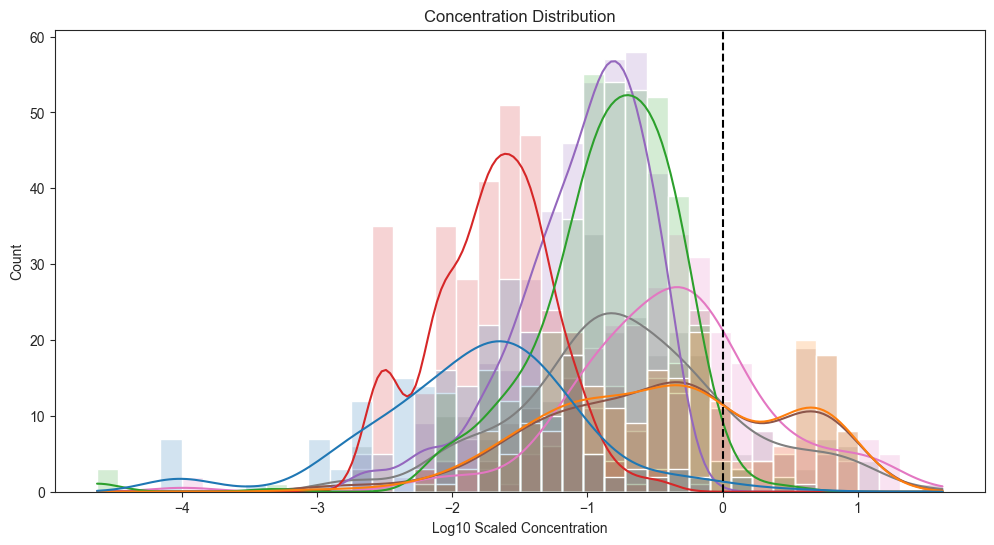

In [79]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(mix_hist, x='Value (mg per L) Scaled', hue="Analyte", palette=colours, legend=False, log_scale=False, kde=True, alpha=0.2)
plt.autoscale(False)
plt.plot([0,0],[0,500], ls='--', color='black')
plt.xlabel('Log10 Scaled Concentration')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Concentration Distribution')

By visualising a histogram of the scaled concentration data, it is clear that the data is not normally distributed. Furthermore, each analyte's peak count is skewed negatively from the mean (black dashed line), indicating that the outlier concentration readings are primarily a high concentration count. It's important to mention that there is minimum quantitative limit on each concentration. Next, there is a few key similarities between the distributions of multiple analytes. DON and FRP (Green and Purple) show a strong correlation, both in terms of variance and mean. A strong correlation can also be seen with DIN and ON (Orange and Brown), which is likely due to overlap in their analyte pools, $NO_{x}$. This correlation is strong throughout all the data, indicating that their overlapping particles are the primary particles within the sites. This can be better visualised in the next plot.

Text(0.5, 1.0, 'Concentration of Each Analyte')

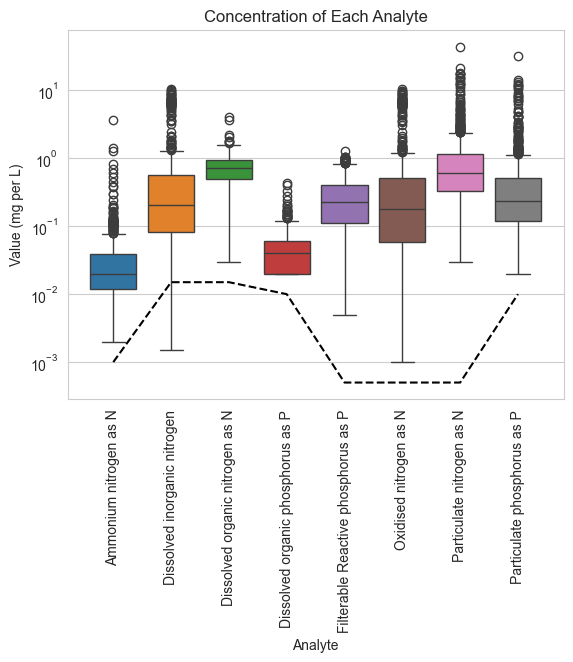

In [26]:
# box plot of concentration
lower_limit = [0.002, 0.03, 0.03, 0.02, 0.001, 0.001, 0.001, 0.02]
lower_limit = [val * 0.5 for val in lower_limit]
limit_df = pd.DataFrame({'Analyte': all_analyte,'lower_limit': lower_limit})
sns.boxplot(mix_hist, x='Analyte', y='Value (mg per L)', hue='Analyte', legend=False)
plt.xticks(rotation=90)
sns.lineplot(limit_df, x='Analyte', y='lower_limit', ls='--', color='k')
plt.yscale('log')
plt.title('Concentration of Each Analyte')

Each analyte contains a significant number of outliers that stretch far beyond the limit of the upper whisker. These values are likely due to flood periods, wherein heavy rainfall causes increased erosion and runoff, resulting in higher concentrations of analytes. Furthermore, analytes with higher average concentrations tend to be analytes formed from natural sources, such as DON and PN, while analytes from agricultural or waste sources have lower averages. However, this doesn't seem to align with DOP, indicating that there is a limited bioavailability of organic waste, or that efficient DOP utilisation by micro-organisms caused the concentrations to be limited.

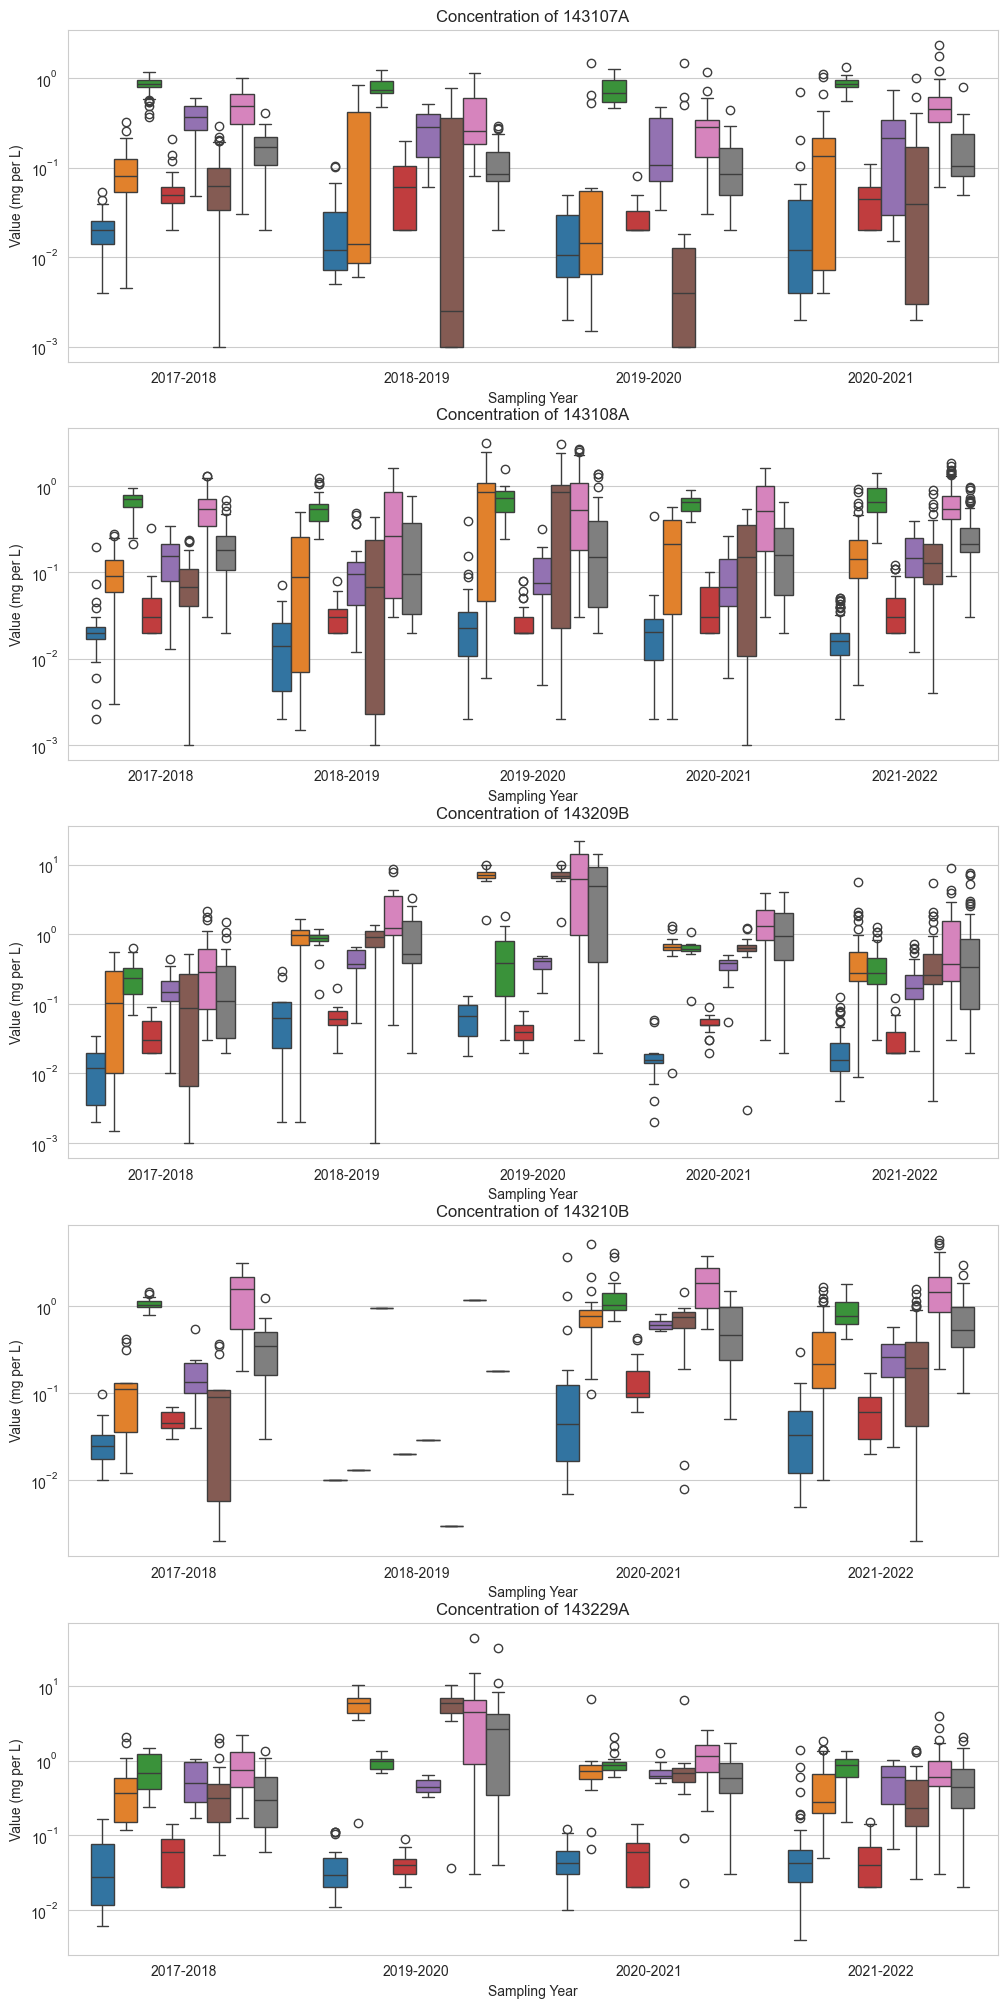

In [27]:
fig, axes = plt.subplots(nrows=len(site_codes), figsize=(12, len(site_codes) * 5))
for plot, site in enumerate(site_codes):
    ax = sns.boxplot(mix_hist[mix_hist['Site Code'] == site], x='Sampling Year',y='Value (mg per L)', hue='Analyte', ax=axes[plot], legend=False)
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    axes[plot].set_yscale('log')
    axes[plot].set_title(f'Concentration of {site}')

To better understand these trends, the above Figure splits this visualisation into separate years and sites. Firstly, it is apparent that the relation between the average concentrations is incredibly consistent between the given sampling years and sites, wherein DON, PN and PP reliably have the highest average concentrations. Next, within site 143107A and 143108A, the interquartile range for both DIN and ON are consistently larger than that of other analytes, possibly due to agricultural periods of higher runoff, or of fluctuations in available nitrogen dense plant matter. This is better visualised in the Figure containing all concentration entries, wherein clear clusters of DIN ON are present at all sites through various periods, but more intensely between 2020 and 2021.

In [98]:
# t test loop
def welch_df(data1, data2):
    var1 = np.var(data1)
    len1 = len(data1)
    var2 = np.var(data2)
    len2 = len(data2)
    return np.floor((var1/len1 + var2/len2)**2 /(((var1/len1)**2)/(len1-1) + ((var2/len2)**2)/(len2-1)))

alpha = 0.05
all_t_test_df = pd.DataFrame(columns = ['Site',
                                        'Year_1',
                                        'Year_2',
                                        'Sampling Years',
                                        'Analyte',
                                        'mean change to last year',
                                        't-stat to last year',
                                        't-crit to last year',
                                        'p-value to last year',
                                        'mean change to average',
                                        't-stat to average',
                                        't-crit to average',
                                        'p-value to average'])
for i, site in enumerate(site_codes):
    site_data = annual_concentration_clean[annual_concentration_clean['Site Code'] == site]
    for year_id, year in enumerate(all_year[1:]):
        year_data_1 = site_data[site_data['Sampling Year'] == year]
        year_data_2 = site_data[site_data['Sampling Year'] == all_year[year_id]] # back one year
        for analyte in all_analyte:
            analyte_data_1 = year_data_1[year_data_1['Analyte'] == analyte]['Value (mg per L)']
            analyte_data_2 = year_data_2[year_data_2['Analyte'] == analyte]['Value (mg per L)']
            mean_data = annual_concentration_clean[(annual_concentration_clean['Site Code'] == site) & (annual_concentration_clean['Analyte'] == analyte)]['Value (mg per L)']
            if len(analyte_data_1) == 0 or len(analyte_data_2) == 0:
                continue

            mean_change_last = np.mean(analyte_data_1) - np.mean(analyte_data_2)
            mean_change_avg = np.mean(analyte_data_1) - np.mean(mean_data)

            # t test between years
            var_list = [np.var(analyte_data_1), np.var(analyte_data_2)]
            if max(var_list) / min(var_list) > 4: # a normal t test is appropriate
                t_stat_last, p_value_last = ttest_ind(analyte_data_1, analyte_data_2, equal_var=True)
                df = len(analyte_data_1) + len(analyte_data_2) - 2
                t_critical_last = stats.t.ppf(1 - alpha/2, df)
            else:
                t_stat_last, p_value_last = ttest_ind(analyte_data_1, analyte_data_2, equal_var=False)
                df = welch_df(analyte_data_1, analyte_data_2)
                t_critical_last = stats.t.ppf(1 - alpha/2, df)

            # t test between average
            var_list = [np.var(analyte_data_1), np.var(mean_data)]
            if max(var_list) / min(var_list) > 4: # a normal t test is appropriate
                t_stat_avg, p_value_avg = ttest_ind(analyte_data_1, mean_data, equal_var=True)
                df = len(analyte_data_1) + len(mean_data) - 2
                t_critical_avg= stats.t.ppf(1 - alpha/2, df)
            else:
                t_stat_avg, p_value_avg = ttest_ind(analyte_data_1, mean_data, equal_var=False)
                df = welch_df(analyte_data_1, mean_data)
                t_critical_avg = stats.t.ppf(1 - alpha/2, df)

            data_list = pd.DataFrame({'Site': [site],
                                      'Year_1': [year],
                                      'Year_2': [all_year[year_id]],
                                      'Sampling Years': [f'{all_year[year_id][:4]}-{year[-4:]}'],
                                      'Analyte': [analyte],
                                      'mean change to last year': [mean_change_last],
                                      't-stat to last year': [t_stat_last],
                                      't-crit to last year': [t_critical_last],
                                      'p-value to last year': [p_value_last],
                                      'mean change to average': [mean_change_avg],
                                      't-stat to average': [t_stat_avg],
                                      't-crit to average': [t_critical_avg],
                                      'p-value to average': [p_value_avg]})

            all_t_test_df = pd.concat([all_t_test_df, data_list], ignore_index=True)

all_t_test_df

C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\3037573413.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  if max(var_list) / min(var_list) > 4: # a normal t test is appropriate
C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\3037573413.py:51: RuntimeWarning: divide by zero encountered in double_scalars
  if max(var_list) / min(var_list) > 4: # a normal t test is appropriate


,Site,Year_1,Year_2,Sampling Years,Analyte,mean change to last year,t-stat to last year,t-crit to last year,p-value to last year,mean change to average,t-stat to average,t-crit to average,p-value to average
0,143107A,2018-2019,2017-2018,2017-2019,Ammonium nitrogen as N,0.005632,1.349163,1.987608,0.180785,-0.001981,-0.140313,1.976233,0.888605
1,143107A,2018-2019,2017-2018,2017-2019,Dissolved inorganic nitrogen,0.099058,2.772938,1.98729,0.006781,0.050344,0.81079,2.055529,0.42475
2,143107A,2018-2019,2017-2018,2017-2019,Dissolved organic nitrogen as N,-0.052874,-1.213508,2.032245,0.233245,-0.037704,-0.902498,2.04523,0.374096
3,143107A,2018-2019,2017-2018,2017-2019,Dissolved organic phosphorus as P,0.017527,1.390946,2.063899,0.176654,0.018253,1.460561,2.063899,0.157148
4,143107A,2018-2019,2017-2018,2017-2019,Filterable Reactive phosphorus as P,-0.105869,-2.991187,2.032245,0.005151,-0.038944,-1.127162,2.039513,0.268243
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,143229A,2021-2022,2020-2021,2020-2022,Dissolved organic phosphorus as P,-0.006566,-0.88676,2.006647,0.379304,-0.002782,-0.580655,1.977692,0.562439
116,143229A,2021-2022,2020-2021,2020-2022,Filterable Reactive phosphorus as P,-0.120616,-2.651128,1.986979,0.00949,-0.01908,-0.470653,1.978524,0.638683
117,143229A,2021-2022,2020-2021,2020-2022,Oxidised nitrogen as N,-0.479903,-3.330188,1.984217,0.00122,-0.900766,-3.565978,1.970563,0.000443
118,143229A,2021-2022,2020-2021,2020-2022,Particulate nitrogen as N,-0.399751,-2.793276,2.009575,0.00743,-0.855695,-1.816354,1.970563,0.070647


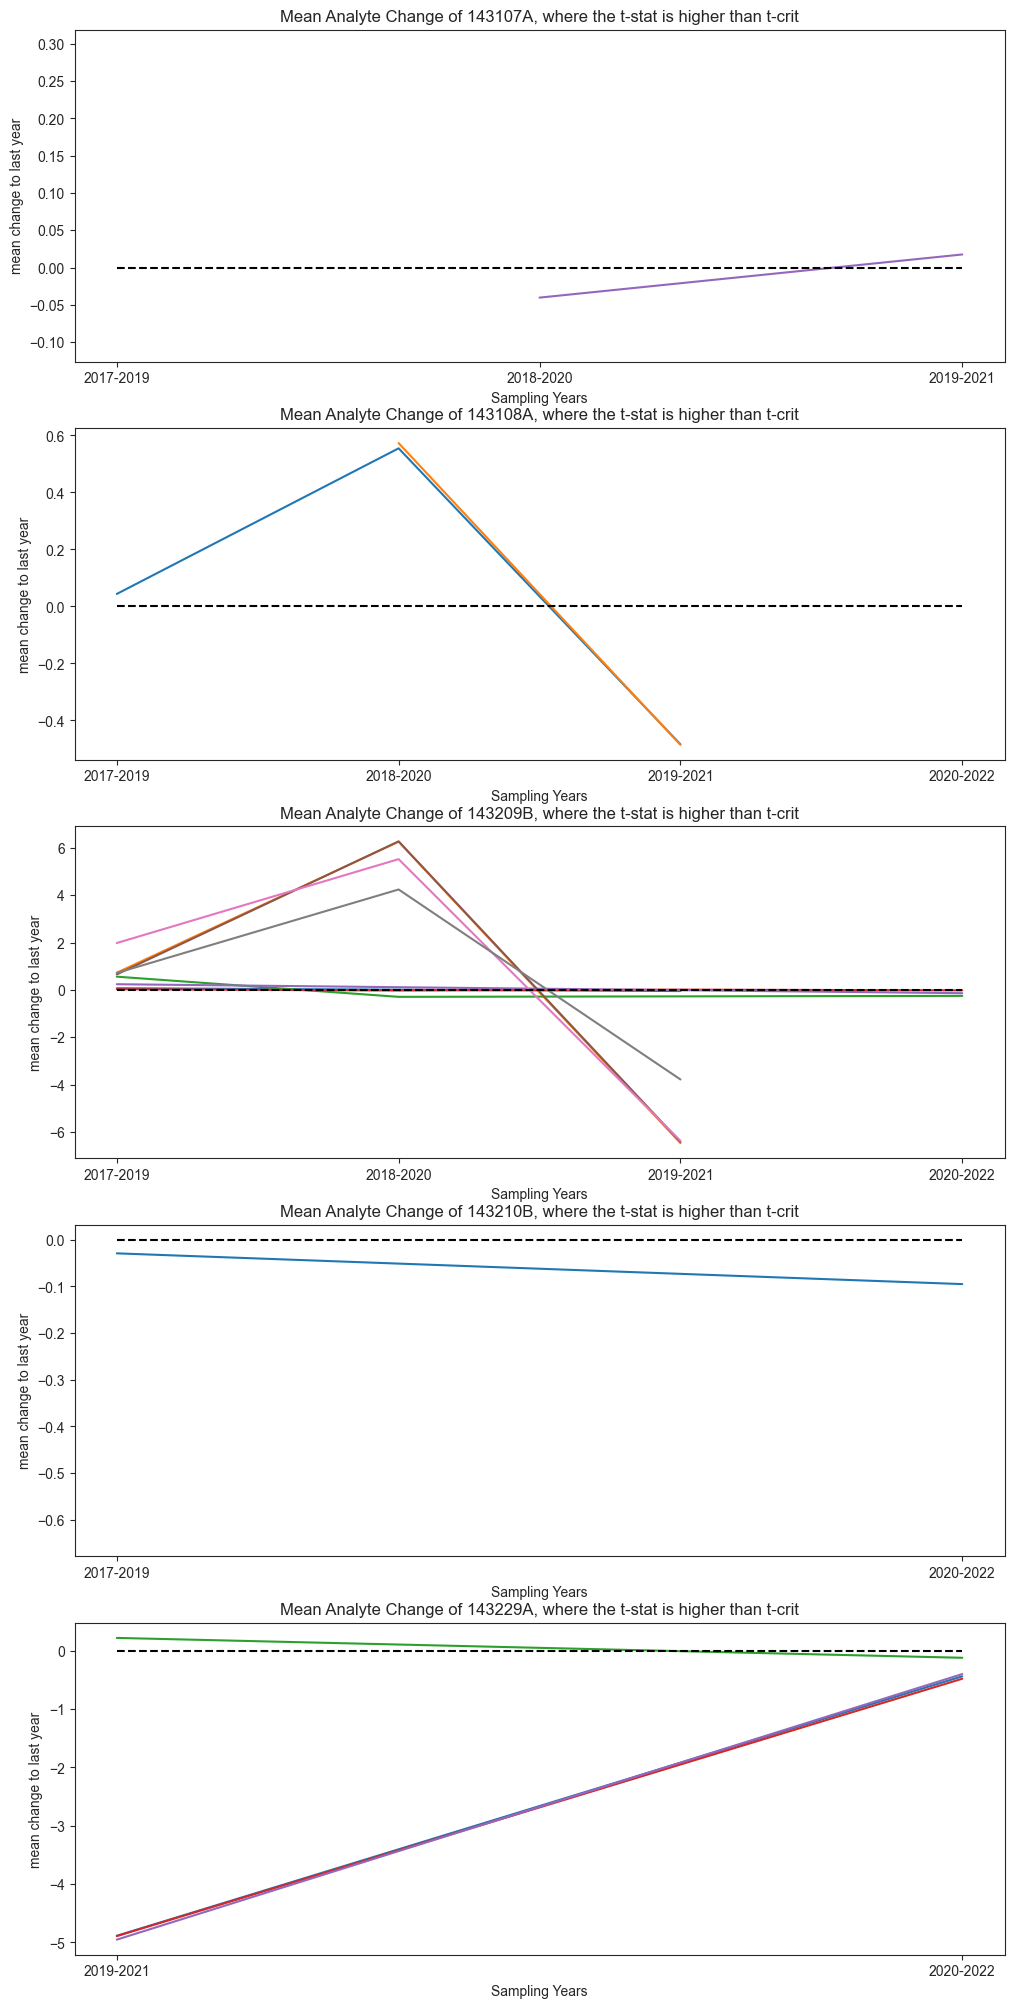

In [107]:
t_crit_mask = all_t_test_df['t-crit to last year'] < abs(all_t_test_df['t-stat to last year']) # if the t-stat is greater than the t-crit, then the p value is less than 0.05, and the null hypothesis is rejected
all_t_test_last = all_t_test_df
all_t_test_last = all_t_test_last.mask(~t_crit_mask, 0, axis=0)

fig, axes = plt.subplots(nrows=len(site_codes), figsize=(12, len(site_codes) * 5))
for plot, site in enumerate(site_codes):
    site_data = all_t_test_last[all_t_test_last['Site'] == site]
    ax = sns.lineplot(site_data, x='Sampling Years',y='mean change to last year', hue='Analyte', ax=axes[plot], legend=False)
    axes[plot].plot([0, len(site_data['Sampling Years'].unique())-1],[0,0], ls='--', color='k')
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    axes[plot].set_title(f'Mean Analyte Change of {site}, where the t-stat is higher than t-crit')

 The above figure provides a visualisation on the change between means per year, filtered to only show statistically significant mean changes. Due to a lack of significant data, it is difficult to interpret most changes in mean, however there are a couple simple trends. The most prominent is the large positive difference between the two sampling periods between 2018 and 2020, this is the same peak I have discussed previously; this peak also caused the fall of for the comparison between the sampling years 2019-2021. Furthermore, I've calculated a t-test to average concentrations for each analyte, however, due to the high concentrations in 2019-2020, and the data only containing 5 years worth of data, this is currently quite unreliable; as more data is collected, this will become a more reliable method to statistically test for outliers. For the sake of completion, I will provide the same visualisation for the t-test to average concentrations.

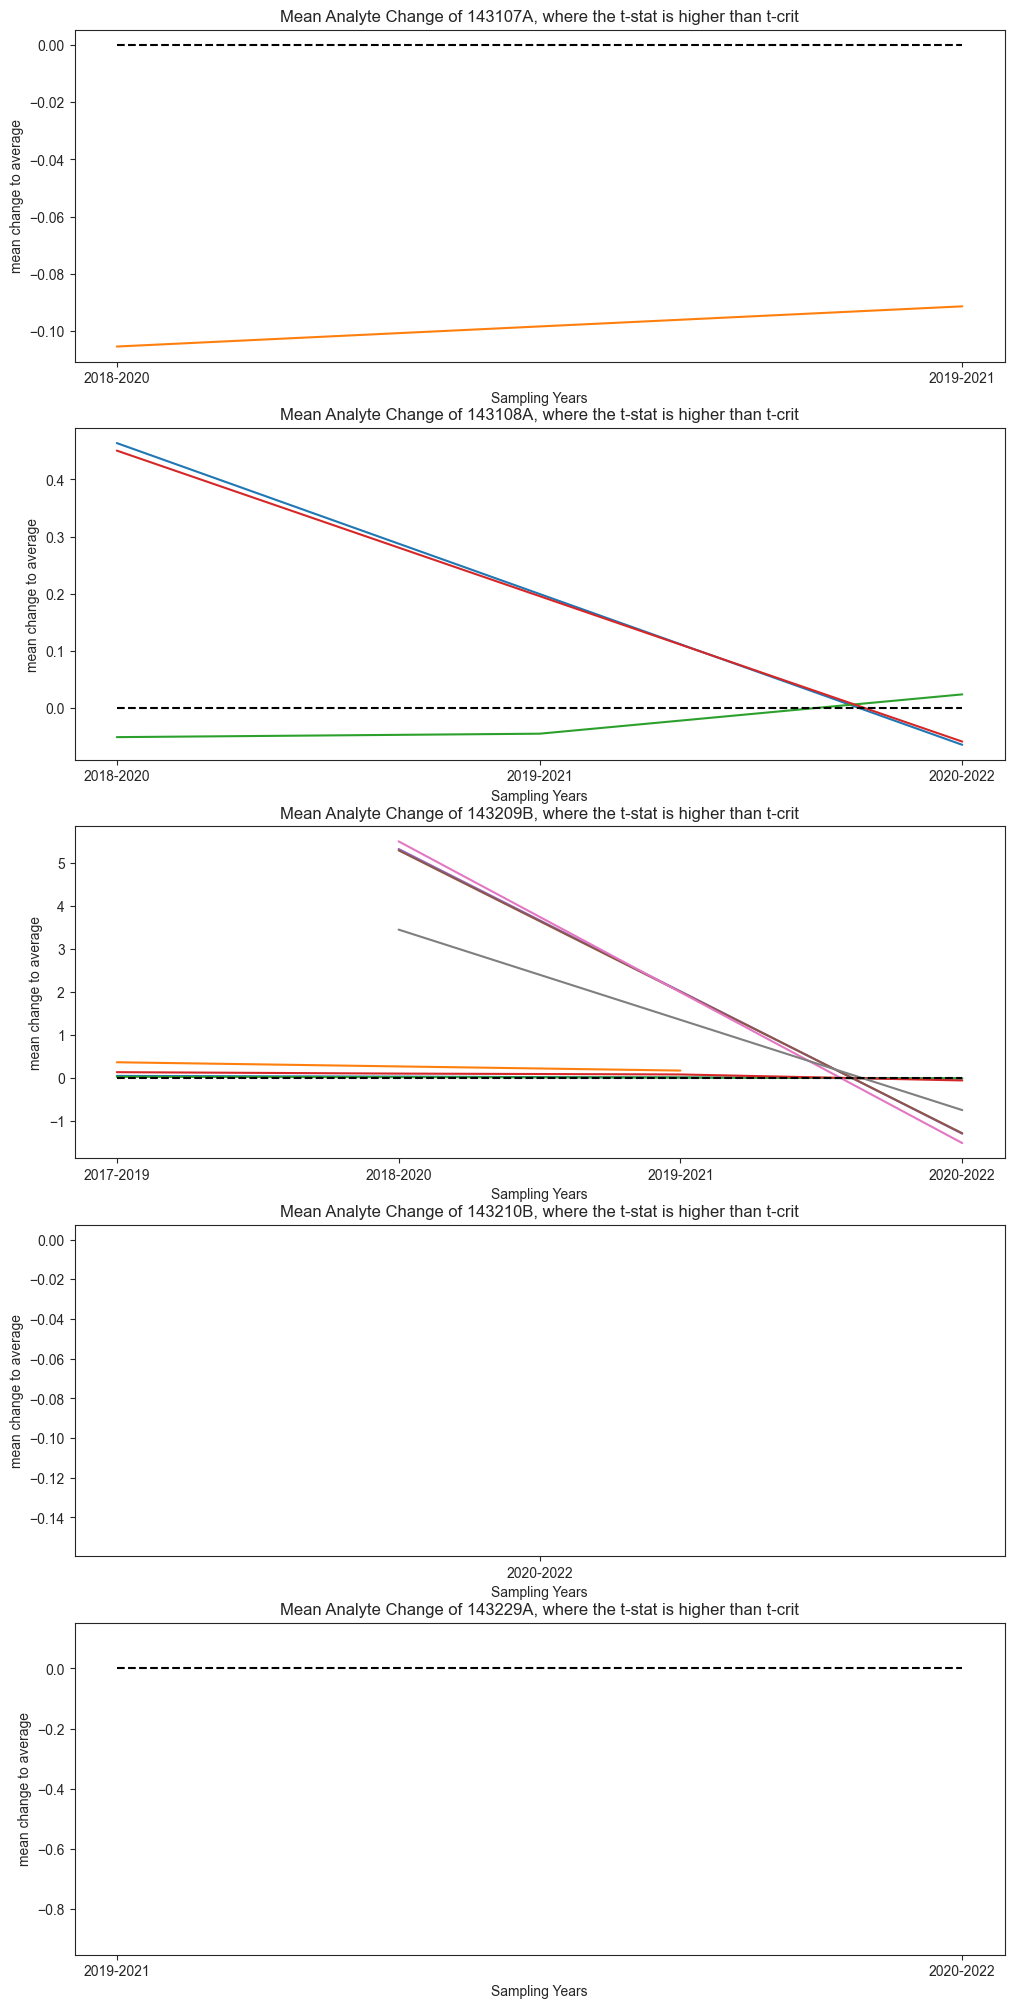

In [108]:
t_crit_mask = all_t_test_df['t-crit to average'] < abs(all_t_test_df['t-stat to average']) # if the t-stat is greater than the t-crit, then the p value is less than 0.05, and the null hypothesis is rejected
all_t_test_last = all_t_test_df
all_t_test_last = all_t_test_last.mask(~t_crit_mask, 0, axis=0)

fig, axes = plt.subplots(nrows=len(site_codes), figsize=(12, len(site_codes) * 5))
for plot, site in enumerate(site_codes):
    site_data = all_t_test_last[all_t_test_last['Site'] == site]
    ax = sns.lineplot(site_data, x='Sampling Years',y='mean change to average', hue='Analyte', ax=axes[plot], legend=False)
    axes[plot].plot([0, len(site_data['Sampling Years'].unique())-1],[0,0], ls='--', color='k')
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    axes[plot].set_title(f'Mean Analyte Change of {site}, where the t-stat is higher than t-crit')

### Load Data

In [30]:
load_weights_statistics_yearly

,Year,Analyte,mean,std,min,25%,50%,75%,max,count
0,2017-2018,Ammonium nitrogen as N,0.3572,0.502827,0.025,0.053,0.058,0.45,1.2,5.0
1,2017-2018,Dissolved inorganic nitrogen,1.974,2.338435,0.13,0.64,1.3,1.8,6.0,5.0
2,2017-2018,Dissolved organic nitrogen as N,10.8,14.704251,0.9,0.9,1.2,17.0,34.0,5.0
3,2017-2018,Dissolved organic phosphorus as P,0.6542,0.822905,0.041,0.1,0.13,1.1,1.9,5.0
4,2017-2018,Filterable Reactive phosphorus as P,3.638,4.158031,0.15,0.64,1.1,7.5,8.8,5.0
5,2017-2018,Oxidised nitrogen as N,1.636,1.847561,0.1,0.58,1.3,1.4,4.8,5.0
6,2017-2018,Particulate nitrogen as N,9.04,12.208726,1.2,2.0,2.3,9.7,30.0,5.0
7,2017-2018,Particulate phosphorus as P,3.736,5.276976,0.38,1.1,1.1,3.1,13.0,5.0
8,2018-2019,Ammonium nitrogen as N,0.055667,0.047816,0.02,0.0285,0.037,0.0735,0.11,3.0
9,2018-2019,Dissolved inorganic nitrogen,0.513333,0.398288,0.17,0.295,0.42,0.685,0.95,3.0


### Annual Flow Data

In [31]:
site_codes = annual_flow_clean['Site Code'].unique()
all_years = annual_flow_clean['Sampling Year'].unique()
all_days = [f'{date[6:10]}/{date[3:5]}/{date[0:2]}' for date in annual_flow_clean['Date Time']]
annual_flow_clean['Day'] = all_days
all_days = pd.Series(all_days).sort_values().unique()
all_months = [f'{date[6:10]}/{date[3:5]}'  for date in annual_flow_clean['Date Time']]
annual_flow_clean['Month'] = all_months
all_months = pd.Series(all_months).sort_values().unique()
all_months

C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\1654387908.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_flow_clean['Day'] = all_days
C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\1654387908.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_flow_clean['Month'] = all_months


array(['2017/07', '2017/08', '2017/09', '2017/10', '2017/11', '2017/12',
       '2018/01', '2018/02', '2018/03', '2018/04', '2018/05', '2018/06',
       '2018/07', '2018/08', '2018/09', '2018/10', '2018/11', '2018/12',
       '2019/01', '2019/02', '2019/03', '2019/04', '2019/05', '2019/06',
       '2019/07', '2019/08', '2019/09', '2019/10', '2019/11', '2019/12',
       '2020/01', '2020/02', '2020/03', '2020/04', '2020/05', '2020/06',
       '2020/07', '2020/08', '2020/09', '2020/10', '2020/11', '2020/12',
       '2021/01', '2021/02', '2021/03', '2021/04', '2021/05', '2021/06',
       '2021/07', '2021/08', '2021/09', '2021/10', '2021/11', '2021/12',
       '2022/01', '2022/02', '2022/03', '2022/04', '2022/05', '2022/06'],
      dtype=object)

<AxesSubplot:xlabel='Time', ylabel='Site'>

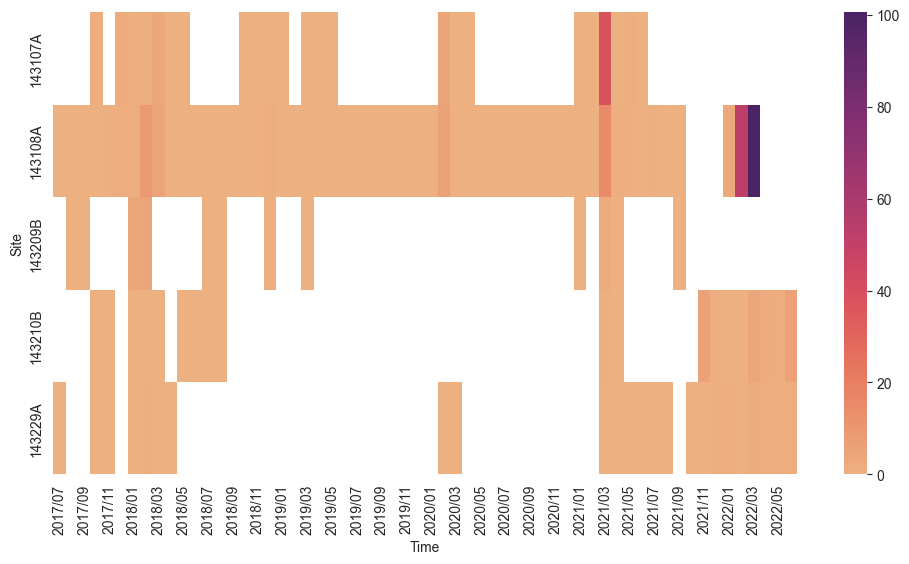

In [32]:
# just a quick look at the flow data
flow_monthly = pd.DataFrame(columns = ['Time', 'Site', 'Flow'])
for plot, site in enumerate(site_codes):
    site_data = annual_flow_clean[annual_flow_clean['Site Code'] == site]
    for month in all_months:
        month_data = site_data[site_data['Month'] == month]
        mean_data = np.mean(month_data['Flow Cumecs'])
        data_list = pd.DataFrame({'Time': [month], 'Site': [site], 'Flow': [mean_data]})
        flow_monthly = pd.concat([flow_monthly, data_list], ignore_index=True)

flow_monthly.fillna(-1, inplace=True)
flow_heat = flow_monthly.pivot('Site','Time','Flow')
flow_heat = flow_heat[all_months]
fig = plt.figure(figsize=(12, 6))
sns.heatmap(flow_heat, cmap="flare", mask=flow_heat == -1)

Lastly, the above figure shows the flow rate over the given months, however due to the low sampling consistency of four of these sites, the overall site-dependent flow patters are difficult to observe.

In [33]:
flow_monthly_statistics = pd.DataFrame(columns = ['Time', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
for month in all_months:
    month_data = annual_flow_clean[annual_flow_clean['Month'] == month]
    flow_data = month_data['Flow Cumecs']
    data_list = pd.DataFrame({'Time': [month]})
    data_list_all = pd.concat([data_list.T, flow_data.describe()]).T
    flow_monthly_statistics = pd.concat([flow_monthly_statistics, data_list_all], ignore_index=True)
flow_monthly_statistics

,Time,mean,std,min,25%,50%,75%,max,count
0,2017/07,0.189172,0.066636,0.0,0.1325,0.2007,0.2345,0.325,765.0
1,2017/08,0.072704,0.040149,0.0,0.0535,0.077,0.1045,0.1415,882.0
2,2017/09,0.046279,0.035892,0.0,0.0217,0.03485,0.075,0.1325,888.0
3,2017/10,0.278007,0.492442,0.0,0.0319,0.154,0.294875,5.7445,1614.0
4,2017/11,0.354836,0.584621,0.0,0.000675,0.1765,0.3594,4.2322,1090.0
5,2017/12,1.623254,2.948769,0.012,0.250675,0.78775,1.793775,26.603,1228.0
6,2018/01,0.539757,1.355579,0.0,0.0032,0.0785,0.2635,9.7565,1973.0
7,2018/02,4.100793,16.93909,0.0,0.015,0.10075,0.3767,132.5712,1672.0
8,2018/03,2.457381,8.08067,0.0,0.011,0.1647,1.16165,78.7569,2260.0
9,2018/04,0.115728,0.260276,0.0,0.004,0.0387,0.1665,3.0785,1727.0


(-50.0, 50.0)

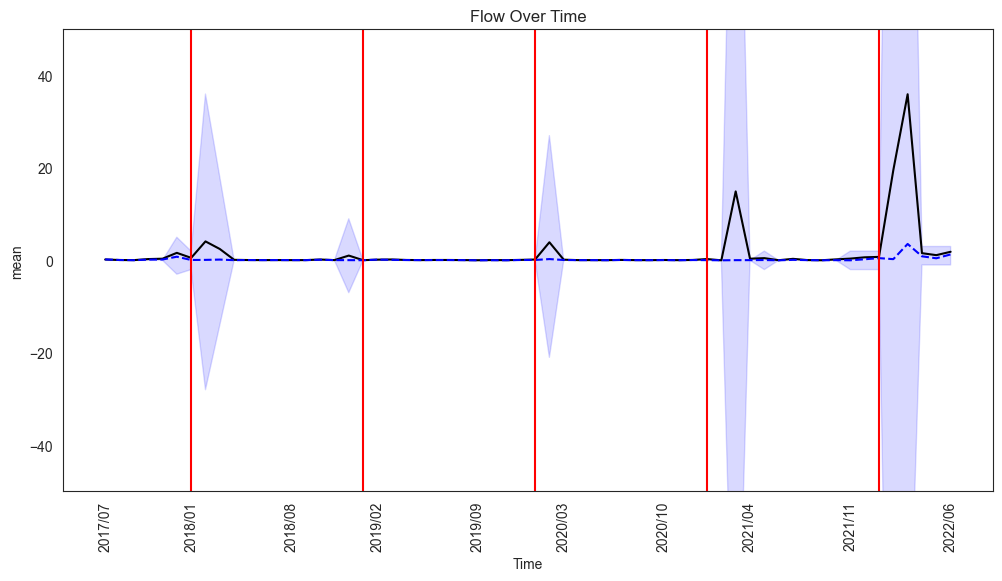

In [34]:

fig = plt.figure(figsize=(12, 6))
sns.set_style("white")
ax = sns.lineplot(data=flow_monthly_statistics, x='Time', y='mean', color='black')
std = 2 * flow_monthly_statistics['std'].astype(int)
x_values = flow_monthly_statistics['Time']
mean = np.array(flow_monthly_statistics['mean'], dtype=int)
ax.fill_between(x_values, mean - std, mean + std, color='b', alpha=.15)
sns.lineplot(data=flow_monthly_statistics, x='Time', y='50%', ls='--', color='blue')
for year in [2018,2019,2020,2021,2022]:
    plt.plot([f'{year}/01', f'{year}/01'],[-50, 50], color='red')
plt.xticks(rotation=90)
x_ticks = np.linspace(0, len(all_months) - 1, 10, dtype=int)
plt.xticks(x_ticks, [all_months[i] for i in x_ticks])
plt.title('Flow Over Time')
plt.ylim(-50,50)

Instead, the above Figure provides an averaged monthly visualisation based only on all entries. Firstly, the average flow follows an annual cycle, peaking over summer, while remaining consistent for the rest of the year. Interestingly, a peak in the median flow does not always follow a peak in the average flow, indicating that high flow rate are only present in some sites, or that heavy rainfall/flow lasted less than half of the month.

In [35]:
flow_daily_statistics = pd.DataFrame(columns = ['Time', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
for day in all_days:
    day_data = annual_flow_clean[annual_flow_clean['Day'] == day]
    flow_data = day_data['Flow Cumecs']
    data_list = pd.DataFrame({'Time': [day]})
    data_list_all = pd.concat([data_list.T, flow_data.describe()]).T
    flow_daily_statistics = pd.concat([flow_daily_statistics, data_list_all], ignore_index=True)

C:\Users\eddie\AppData\Local\Temp\ipykernel_33700\2665619974.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_daily_statistics_2022.fillna(0, inplace=True)


(-50.0, 700.0)

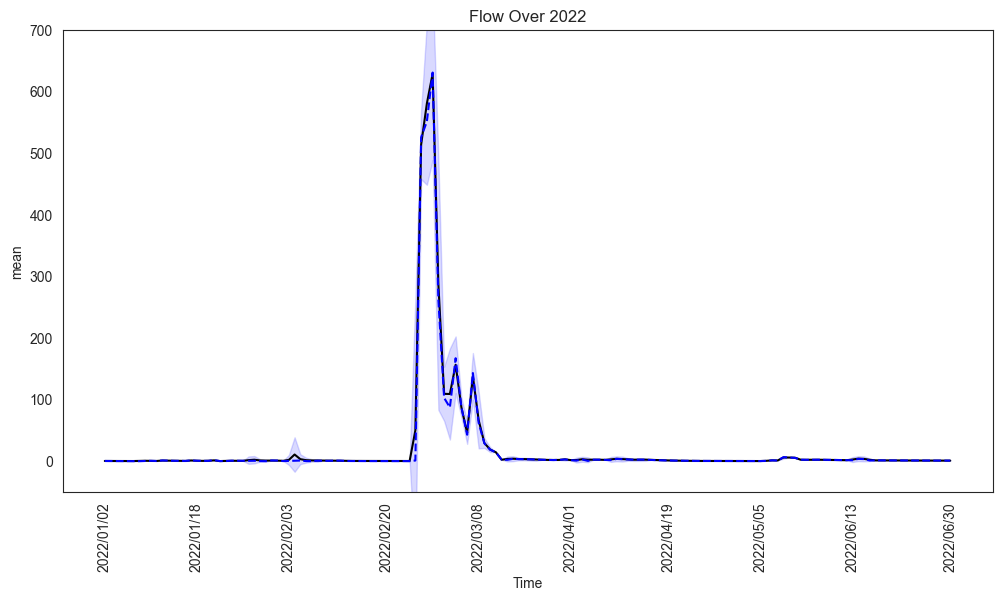

In [36]:
flow_daily_statistics_2022 = flow_daily_statistics[flow_daily_statistics['Time'] > '2022/01/01']
fig = plt.figure(figsize=(12, 6))
sns.set_style("white")
ax = sns.lineplot(data=flow_daily_statistics_2022, x='Time', y='mean', color='black')
flow_daily_statistics_2022.fillna(0, inplace=True)
std = 2 * flow_daily_statistics_2022['std'].astype(int)
x_values = flow_daily_statistics_2022['Time']
ax.fill_between(x_values, flow_daily_statistics_2022['mean'] - std, flow_daily_statistics_2022['mean'] + std, color='b', alpha=.15)
sns.lineplot(data=flow_daily_statistics_2022, x='Time', y='50%', ls='--', color='blue')
plt.xticks(rotation=90)
x_ticks = np.linspace(0, len(flow_daily_statistics_2022) - 1, 10, dtype=int)
plt.xticks(x_ticks, [flow_daily_statistics_2022.iloc[i, 0] for i in x_ticks])
plt.title('Flow Over 2022')
plt.ylim(-50,700)


To more closely examine this, the above Figure is a zoomed in representation of the 2022 flow rates. Importantly, the mean and median line follow each other very closely during the flood period, indicating that the flow rate was constantly high for all entries during these days. Furthermore, the 2 $\sigma$ value is consistently less than that seen in the previous figure, indicating that the flow rate was consistently high during this period. A small spike at 2022/02/03 shows a similar statistics to that seen in the previous figure, indicating that this was a short period of high flow rate, and a figure with daily bins does not provide the resolution to capture the flow.

## 3. Data Fitting and Model Selection

First up, I want to find a bit of data that could use a trendline. As from my thinking before, I think that the analyte content per year for each site could be a good fit for a mode, with further testing each year to see if the model fits future data.

In [42]:
site_codes = annual_concentration_clean['Site Code'].unique()
all_days = []
for date in annual_concentration_clean['Date Time']:
    date_split = date.split('/')
    date_clean = f'{date_split[0]}/{date_split[1]}/{date_split[2][:4]}'
    all_days.append(date_clean)
all_days = pd.Series(all_days).unique()
all_days

array(['03/08/2017', '11/09/2017', '17/10/2017', '18/10/2017',
       '24/10/2017', '21/11/2017', '30/11/2017', '01/12/2017',
       '02/12/2017', '03/12/2017', '04/12/2017', '06/12/2017',
       '07/12/2017', '08/12/2017', '11/12/2017', '12/12/2017',
       '13/12/2017', '14/12/2017', '29/12/2017', '30/12/2017',
       '04/01/2018', '05/01/2018', '06/01/2018', '08/01/2018',
       '23/02/2018', '24/02/2018', '25/02/2018', '26/02/2018',
       '27/02/2018', '28/02/2018', '01/03/2018', '06/03/2018',
       '07/03/2018', '08/03/2018', '12/03/2018', '13/03/2018',
       '14/03/2018', '08/05/2018', '11/06/2018', '06/07/2018',
       '13/08/2018', '13/09/2018', '05/10/2018', '16/10/2018',
       '13/11/2018', '12/12/2018', '17/12/2018', '19/12/2018',
       '09/01/2019', '08/02/2019', '08/03/2019', '17/03/2019',
       '18/03/2019', '19/03/2019', '12/04/2019', '09/05/2019',
       '13/06/2019', '09/07/2019', '07/08/2019', '10/09/2019',
       '08/10/2019', '22/11/2019', '19/12/2019', '16/01

In [66]:
# function to parse through every day in a range
start_year = 1880
end_year = 2124
no_of_leap = abs(start_year - end_year) // 4
leap_year = np.linspace(start_year, end_year, no_of_leap + 1)
def less_than_ten(val):
    # function to add a 0 to the start of a number if it is less than 10
    if val < 10:
        return f'0{val}'
    else:
        return f'{val}'

def date_iterator(date):
    # format for input is '1/1/1216'
    month_days = [31,28,31,30,31,30,31,31,30,31,30,31]
    date_split_function = date.split('/')
    day_function = int(date_split_function[0])
    month_function = int(date_split_function[1])
    year_function = int(date_split_function[2])
    if month_function == 2 and year_function in leap_year:
        month_days[1] = 29
    if day_function < month_days[int(month_function) - 1]:
        return f'{less_than_ten(day_function + 1)}/{less_than_ten(month_function)}/{year_function}'
    else:
        day_function = 1
        if month_function < 12:
            return f'{less_than_ten(day_function)}/{less_than_ten(month_function + 1)}/{year_function}'
        else:
            month_function = 1
            return f'{less_than_ten(day_function)}/{less_than_ten(month_function)}/{year_function + 1}'

In [67]:
# quickly finding the number of days between the first and last date
current_date = all_days[0]
all_all_days = []
max_loops = 10**4
current_loops= 0
final_day = all_days[-1]
print(f'Final day: {final_day}')
while current_date != final_day and current_loops < max_loops:
    current_date = date_iterator(current_date)
    all_all_days.append(current_date)
    current_loops += 1

print(len(all_all_days))

Final day: 12/05/2021
1378


In [68]:
daily_concentrations_df = pd.DataFrame(columns = ['Site', 'Analyte', 'Date', 'Value'])

for site in site_codes:
    site_data = annual_concentration_clean[annual_concentration_clean['Site Code'] == site]
    for analyte in all_analyte:
        analyte_data = site_data[site_data['Analyte'] == analyte]
        for date in all_all_days:
            mask = [date in date_time for date_time in analyte_data['Date Time']]
            date_data = analyte_data[mask]
            if len(date_data) > 0:
                data_list = pd.DataFrame({'Site': [site], 'Analyte': [analyte], 'Date': [date], 'Value': np.mean(date_data['Value (mg per L)'])})
                daily_concentrations_df = pd.concat([daily_concentrations_df, data_list], ignore_index=True)
            else:
                data_list = pd.DataFrame({'Site': [site], 'Analyte': [analyte], 'Date': [date], 'Value': np.nan})
                daily_concentrations_df = pd.concat([daily_concentrations_df, data_list], ignore_index=True)

daily_concentrations_df

,Site,Analyte,Date,Value
0,143107A,Ammonium nitrogen as N,04/08/2017,NaN
1,143107A,Ammonium nitrogen as N,05/08/2017,NaN
2,143107A,Ammonium nitrogen as N,06/08/2017,NaN
3,143107A,Ammonium nitrogen as N,07/08/2017,NaN
4,143107A,Ammonium nitrogen as N,08/08/2017,NaN
...,...,...,...,...
55115,143229A,Particulate phosphorus as P,08/05/2021,NaN
55116,143229A,Particulate phosphorus as P,09/05/2021,NaN
55117,143229A,Particulate phosphorus as P,10/05/2021,NaN
55118,143229A,Particulate phosphorus as P,11/05/2021,NaN


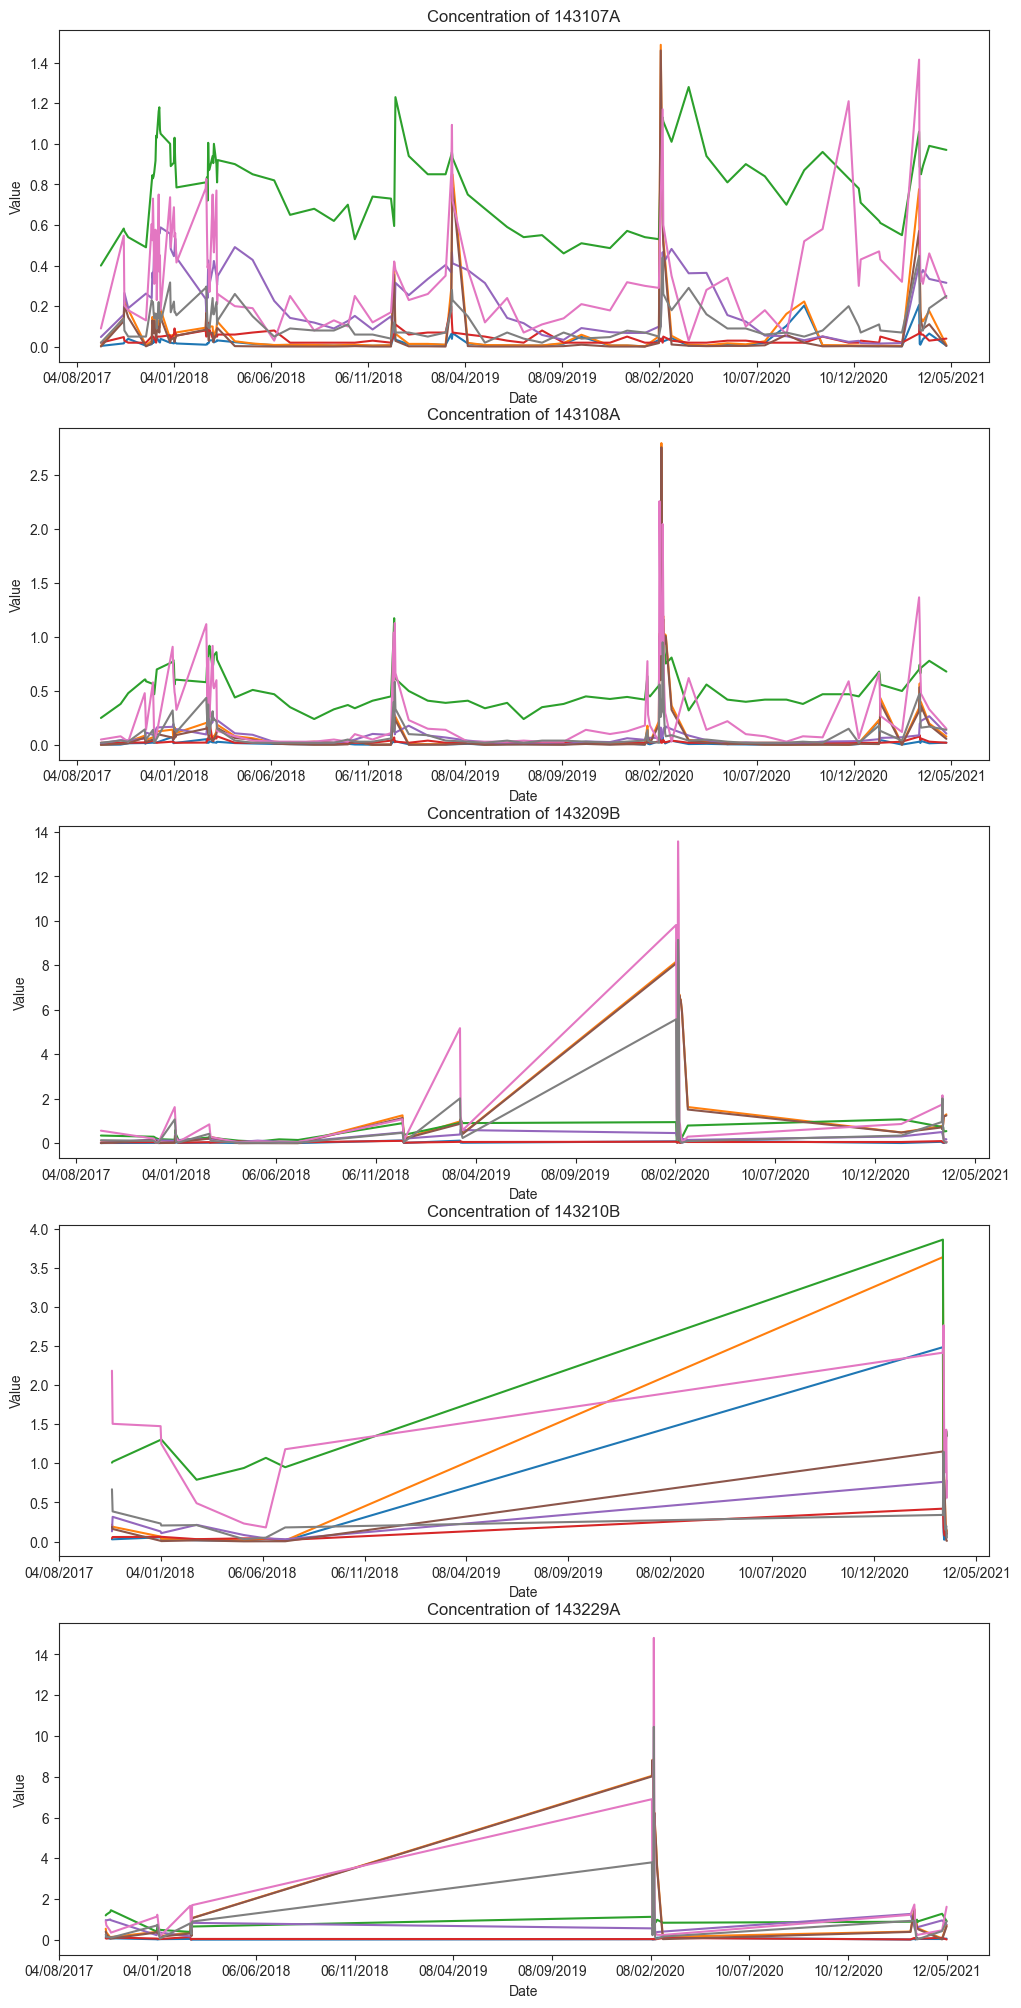

In [69]:
no_date_ticks = 10
date_choices = np.linspace(0, len(all_all_days)-1, no_date_ticks, dtype=int)
date_ticks = [all_all_days[date] for date in date_choices]
fig, axes = plt.subplots(nrows=len(site_codes), figsize=(12, len(site_codes) * 5))
for plot, site in enumerate(site_codes):
    site_data = daily_concentrations_df[daily_concentrations_df['Site'] == site]
    ax = sns.lineplot(data=site_data, x='Date', y='Value', hue='Analyte', ax=axes[plot], legend=False)
    axes[plot].set_title(f'Concentration of {site}')
    sns.set_style("ticks")
    ax.set(xticks=date_ticks, xticklabels=date_ticks)

To find a reasonable set of data, I first decided on a set of data wherein a model could be built upon further and used to estimate/validate future results. As such, I chose to investigate concentration data of each analyte for each site, as seen in the above figure. Importantly, to fit a model to this data, it required a uniform collection dates. To simplify this process, every day there is a sample collection, all entries from that date will be averaged. If there was no sample on the date, each concentration will not be given a number. This ensures a more highly sampled day is not weighted higher than a lowly sampled day.
While a model fit to all concentration data could be utlised effectively to predict cycles, it is clear that there is a severe lack of consistent sampling to apply any kind of large scale fitting.

[[<matplotlib.axis.XTick at 0x1b9bdd29660>,
 [Text(0.0, 0, '04/08/2017'),
  Text(153.0, 0, '04/01/2018'),
  Text(306.0, 0, '06/06/2018'),
  Text(459.0, 0, '06/11/2018'),
  Text(612.0, 0, '08/04/2019'),
  Text(765.0, 0, '08/09/2019'),
  Text(918.0, 0, '08/02/2020'),
  Text(1071.0, 0, '10/07/2020'),
  Text(1224.0, 0, '10/12/2020'),
  Text(1377.0, 0, '12/05/2021')]]

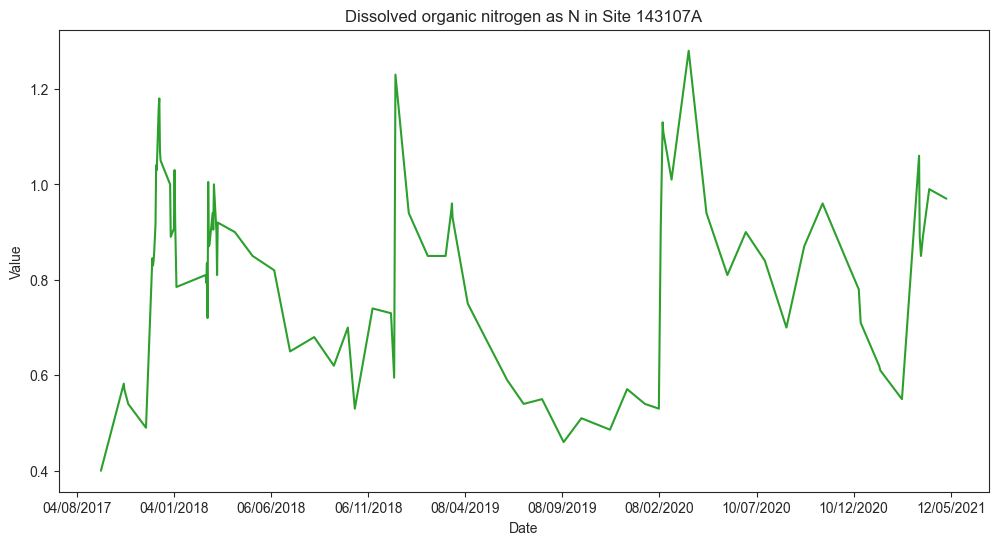

In [70]:
model_data_df = daily_concentrations_df[daily_concentrations_df['Site'] == site_codes[0]]
model_data_df = model_data_df[model_data_df['Analyte'] == 'Dissolved organic nitrogen as N']
model_data_df = model_data_df.drop(columns=['Site', 'Analyte'])
model_data_df.reset_index(drop=True, inplace=True)
import matplotlib.colors as mcolors
colours = [mcolors.TABLEAU_COLORS[colour] for colour in mcolors.TABLEAU_COLORS.keys()]

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=model_data_df, x='Date', y='Value', color=colours[2])
sns.set_style("ticks")
plt.title('Dissolved organic nitrogen as N in Site 143107A')
ax.set(xticks=date_ticks, xticklabels=date_ticks)

An analyte with consistent sampling is DON 143107A. Moreover, every 13 or so months it looks like it peaks, then teeters off. I'll try to fit a model to this data. First up, linear using old code.

In [71]:
model_data_df['id'] = np.linspace(0, len(model_data_df)-1, len(model_data_df))
model_data_df.dropna(inplace=True)
model_data_df

,Date,Value,id
38,11/09/2017,0.4,38.0
74,17/10/2017,0.5825,74.0
75,18/10/2017,0.57,75.0
81,24/10/2017,0.54,81.0
109,21/11/2017,0.49,109.0
...,...,...,...
1329,25/03/2021,0.87,1329.0
1330,26/03/2021,0.85,1330.0
1333,29/03/2021,0.89,1333.0
1343,08/04/2021,0.99,1343.0


Text(0.5, 1.0, 'Dissolved organic nitrogen as N in Site 143107A')

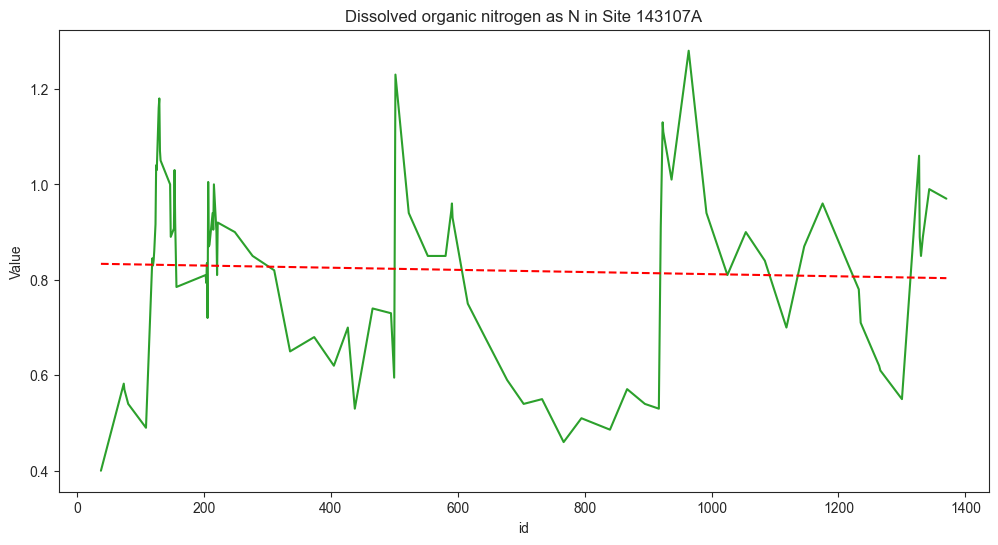

In [72]:
from scipy.optimize import curve_fit

def straight_line(x, m, c):
    return m * x + c

x_data = model_data_df['id']
y_data = model_data_df['Value']
popt, pcov = curve_fit(straight_line, x_data, y_data, p0=[1, 1]) # Initial guesses for a, b, c

x_model = np.linspace(model_data_df['id'].min(), model_data_df['id'].max(), 100) # Generate x values for the model
y_model = straight_line(x_model, *popt) # Generate y values using the model

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=model_data_df, x='id', y='Value', color=colours[2])
plt.plot(x_model, y_model, c='r', ls='--', label='Model')
sns.set_style("ticks")
plt.title('Dissolved organic nitrogen as N in Site 143107A')

Hmm, i thought that would be the perfect fit.

In [73]:
def sine_wave(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

def reverse_sawtooth(x, a, n, f, c, d):
    j = 0
    for k in range(int(n)):
        k += 1
        j += (-1)**k * (np.sin(2 * np.pi * k * f * (x + c)) / k)
    return (2*a)/np.pi * j + d

In [74]:
popt_sine, pcov = curve_fit(sine_wave, x_data, y_data, p0=[0.3,0.015,0,0.8]) # Initial guesses for a, b, c
covariance_sin = pcov

y_model_sin = sine_wave(x_model, *popt_sine) # Generate y values using the model

popt_saw, pcov = curve_fit(reverse_sawtooth, x_data, y_data, p0=[0.3,5,0.0025,130,0.8]) # Initial guesses for a, b, c
covariance_saw = pcov

y_model_saw = reverse_sawtooth(x_model, *popt_saw) # Generate y values using the model

print(f'Linear Fit: {popt}\n'
      f'Sine Fit: {popt_sine}\n'
      f'Sawtooth Fit: {popt_saw}')

Linear Fit: [-2.25126518e-05  8.34345419e-01]
Sine Fit: [ 0.17925724  0.01568926 -1.27303584  0.76100457]
Sawtooth Fit: [2.26006154e-01 5.00000000e+00 2.47974002e-03 9.87332301e+01
 7.63719685e-01]


C:\Users\eddie\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [75]:
# Using chi2 value for each fit
def chi2_value(y_chi, y_model_chi):
    value_var = np.var(y_chi)
    residuals = (y_model_chi - y_chi)**2
    chi2 = sum(residuals / value_var)
    return chi2

def r2_value(y_chi, y_model_chi):
    residuals = y_chi - y_model_chi
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_chi - np.mean(y_chi))**2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

lin_chi2 = chi2_value(y_data, straight_line(x_data, *popt))
lin_r2 = r2_value(y_data, straight_line(x_data, *popt))
sine_chi2 = chi2_value(y_data, sine_wave(x_data, *popt_sine))
sine_r2 = r2_value(y_data, sine_wave(x_data, *popt_sine))
saw_chi2 = chi2_value(y_data, reverse_sawtooth(x_data, *popt_saw))
saw_r2 = r2_value(y_data, reverse_sawtooth(x_data, *popt_saw))

print(f'Linear Chi2: {lin_chi2}, R2: {lin_r2}\n'
      f'Sine Chi2: {sine_chi2}, R2: {sine_r2}\n'
      f'Sawtooth Chi2: {saw_chi2}, R2: {saw_r2}\n')

Linear Chi2: 89.76373378159879, R2: 0.0026251802044576777
Sine Chi2: 57.95629584201466, R2: 0.35604115731094843
Sawtooth Chi2: 45.15593561360848, R2: 0.49826738207101706



Text(0.5, 1.0, 'Dissolved organic nitrogen as N in Site 143107A')

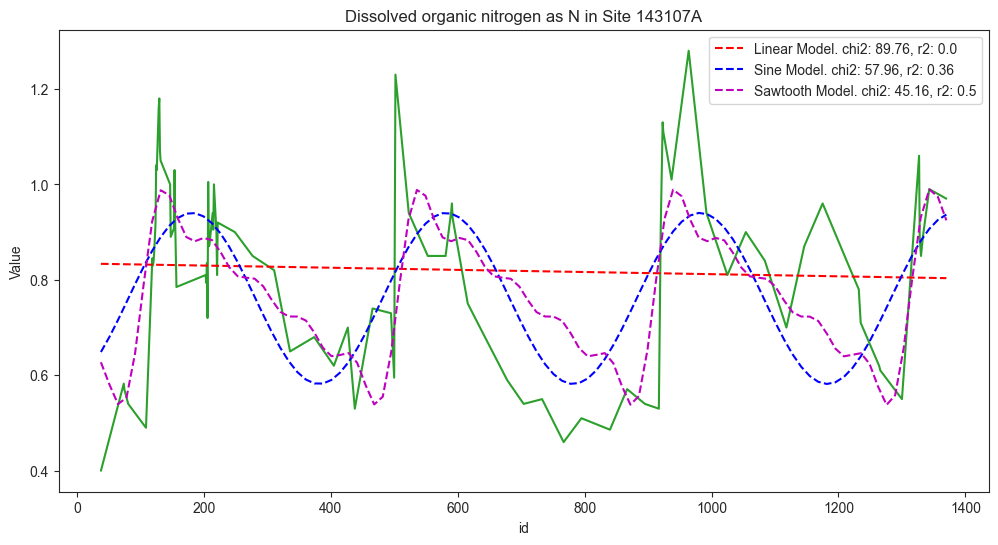

In [76]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_data_df, x='id', y='Value', color=colours[2])
plt.plot(x_model, y_model, c='r', ls='--', label=f'Linear Model. chi2: {round(lin_chi2, 2)}, r2: {round(lin_r2, 2)}')
plt.plot(x_model, y_model_sin, c='b', ls='--', label=f'Sine Model. chi2: {round(sine_chi2, 2)}, r2: {round(sine_r2, 2)}')
plt.plot(x_model, y_model_saw, c='m', ls='--', label=f'Sawtooth Model. chi2: {round(saw_chi2, 2)}, r2: {round(saw_r2, 2)}')
sns.set_style("ticks")
plt.legend()
plt.title('Dissolved organic nitrogen as N in Site 143107A')

All three functions can be seen above. The linear fit unsurprisingly preforms the worst as per both quantitative metrics. A Sine fit preforms better, however it fails to capture both the peaks and troughs of the observed data. The Reverse Sawtooth fit better captures these elements, as it begins at a high point and slowly decreases, producing the lowest chi2 value and highest R2 value, indicating that it is the best fit of the three.